## Load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
import warnings

In [ ]:
warnings.simplefilter(action= 'ignore')
np.random.seed(42)

In [ ]:
categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
sales = pd.read_csv('sales_train.csv')

**Task** : The task is to forecast the total amount of products sold in every shop for the test set.

In [ ]:
def print_unique(df, cols):
    print('File lenght: ', len(df))
    for col in cols:
        print(f'Unique {col}', len(pd.unique(df[col])))

## Look at the data

In [ ]:
shops.sample(3)

shop_name  shop_id
0           !Якутск Орджоникидзе, 56 фран        0
5                  Вологда ТРЦ "Мармелад"        5
36  Новосибирск ТРЦ "Галерея Новосибирск"       36

In [ ]:
categories.sample(3)

item_category_name  item_category_id
69                        Подарки - Сувениры                69
71  Подарки - Сумки, Альбомы, Коврики д/мыши                71
27                          Игры MAC - Цифра                27

In [ ]:
items.head(3)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40

In [ ]:
sales.head(3)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2552       899.0           1.0
2  05.01.2013               0       25     2552       899.0          -1.0

## Checking NaN

In [ ]:
shops.isna().sum(), items.isna().sum(), categories.isna().sum(), sales.isna().sum()

(shop_name    0
 shop_id      0
 dtype: int64, item_name           0
 item_id             0
 item_category_id    0
 dtype: int64, item_category_name    0
 item_category_id      0
 dtype: int64, date              0
 date_block_num    0
 shop_id           0
 item_id           0
 item_price        0
 item_cnt_day      0
 dtype: int64)

There are no NaN values

# Shops

In [ ]:
shops.sample(3)

shop_name  shop_id
39  РостовНаДону ТРК "Мегацентр Горизонт"       39
5                  Вологда ТРЦ "Мармелад"        5
53                       Уфа ТЦ "Семья" 2       53

File contains shop names and their id

In [ ]:
print_unique(shops, shops.columns)

File lenght:  60
Unique shop_name 60
Unique shop_id 60


All names and ids are unique

In [ ]:
shops.dtypes

shop_name    object
shop_id       int64
dtype: object

In [ ]:
max(shops.shop_id)

59

We can cast to a smaller data type to save memory

In [ ]:
shops.shop_id = shops.shop_id.astype(np.int8)

**Note** It looks like the first word is the name of the city. Let's extract city name from shop name and see if it can help.

Also we see duplicates at indexes 0-58, 1-59 

In [ ]:
shops.iloc[0,0] = shops.iloc[0,0][1:]
shops.iloc[1,0] = shops.iloc[1,0][1:]
shops['city'] = [x.split(' ')[0] for x in shops.shop_name]
shops.sample(5)

shop_name  shop_id              city
28  Москва ТЦ "МЕГА Теплый Стан" II       28            Москва
12              Интернет-магазин ЧС       12  Интернет-магазин
52             Уфа ТК "Центральный"       52               Уфа
4          Волжский ТЦ "Волга Молл"        4          Волжский
34             Н.Новгород ТРЦ "РИО"       34        Н.Новгород

In [ ]:
cities = pd.unique(shops['city'])
cities, len(cities)

(array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
        'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
        'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
        'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
        'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
        'Ярославль'], dtype=object), 31)

We see that there are "Интернет-магазин", "Цифровой", "Выездная" which are obviously not cities. Let's leave it the way it is for now. 

Now let's look at how many shops each city has

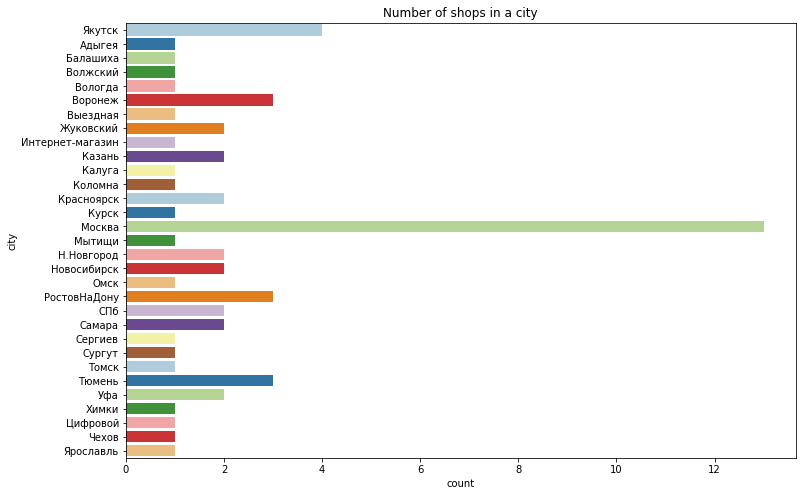

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(y="city", data=shops, palette = 'Paired')
plt.title('Number of shops in a city')
plt.show()

It looks like Moscow has more shops than any other city. It is important to keep in mind that the task contains time variable. So the amount of shops in each city may change with time. This will be invistigated later

# Categories

In [ ]:
categories.sample(3)

item_category_name  item_category_id
48  Книги - Компьютерная литература                48
54                    Книги - Цифра                54
36   Карты оплаты - Windows (Цифра)                36

In [ ]:
print_unique(categories, categories.columns)

File lenght:  84
Unique item_category_name 84
Unique item_category_id 84


All names and ids are unique

In [ ]:
categories.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [ ]:
categories.item_category_id = categories.item_category_id.astype(np.int8)

All the categories are unique. But there are a lot of them. If we look at the structure we'll see that most of the categories follow the pattern '1 - 2' where 2 is additional category

Let's extract category and subcategory and get rid of the words in braces as they represent additional information which may be redundant to the model. Also fill missing subcategories with categories

In [ ]:
categories['cat'] = categories['item_category_name'].str.split(' - ').str.get(0).str.strip().str.split('(').str.get(0).str.strip()
categories['sub_cat'] = categories['item_category_name'].str.split(' - ').str.get(1).str.strip().fillna(categories['cat'])
categories['sub_cat'] = categories['sub_cat'].str.split('(').str.get(0).str.strip()
pd.unique(categories.sub_cat)

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Билеты', 'Доставка товара', 'Прочие',
       'Аксессуары для игр', 'Цифра', 'Дополнительные издания',
       'Коллекционные издания', 'Стандартные издания', 'Карты оплаты',
       'Live!', 'PSN', 'Windows', 'Blu-Ray', 'Blu-Ray 3D', 'Blu-Ray 4K',
       'DVD', 'Коллекционное', 'Артбуки, энциклопедии', 'Аудиокниги',
       'Аудиокниги 1С', 'Бизнес литература', 'Комиксы, манга',
       'Компьютерная литература', 'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры', 'Открытки, наклейки',
       'Развитие', 'Сертификаты, услуги', 'Сувениры',
       'Сумки, Альбомы, Коврики д/мыши', 'Фигурки', '1С:Предприяти

In [ ]:
pd.unique(categories['cat'])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Игры Android', 'Игры MAC', 'Игры PC', 'Карты оплаты',
       'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы', 'Служебные',
       'Чистые носители', 'Элементы питания'], dtype=object)

Let's change all "Игры **** " to just "Игры" to simplify the categories

In [ ]:
categories['cat'] = ['Игры' if x == 'Игры PC' or x == 'Игры Android' or x == 'Игры MAC' else x for x in categories['cat']  ]

In [ ]:
pd.unique(categories['cat'])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Карты оплаты', 'Кино', 'Книги', 'Музыка', 'Подарки',
       'Программы', 'Служебные', 'Чистые носители', 'Элементы питания'],
      dtype=object)

In [ ]:
len(categories), len(pd.unique(categories.sub_cat)), len(pd.unique(categories['cat']))

(84, 59, 15)

So we extracted 15 categories and 59 subcategories

# Items

In [ ]:
items.sample(3)

item_name  item_id  item_category_id
7467        V/A The Sound Of Underground  2     7467                55
9951   ВОЗВРАЩЕНИЕ БУДУЛАЯ  Серии 1-4  2DVD     9951                40
19841                     ТРИ ЧАСА НА ПОБЕГ    19841                40

It looks like very few item names contain valid info about the category. So we'll leave it untouched for now

In [ ]:
print_unique(items, ['item_name', 'item_id'])

File lenght:  22170
Unique item_name 22170
Unique item_id 22170


In [ ]:
items.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [ ]:
items.item_id = items.item_id.astype(np.int16)
items.item_category_id = items.item_category_id.astype(np.int16)

# Sales

In [ ]:
sales.sample(3)

date  date_block_num  shop_id  item_id  item_price  \
1384209  22.02.2014              13       35    17294       149.0   
886867   20.09.2013               8       31    15256      1199.0   
1397815  21.02.2014              13       15     3732      2599.0   

         item_cnt_day  
1384209           1.0  
886867            2.0  
1397815           2.0

In [ ]:
print_unique(sales, ['date_block_num', 'shop_id', 'item_id'])

File lenght:  2935849
Unique date_block_num 34
Unique shop_id 60
Unique item_id 21807


So we have 34 months of observation. 35 - test month

**Note** that prediction is made for the next month, while sales records contain daily data

In [ ]:
sales.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

The fact that count has float type is kind of suspicios. Let's check

In [ ]:
len(sales[sales.item_cnt_day != round(sales.item_cnt_day)])

0

Everything looks fine. Check the max values in order to cast to a smaller type

In [ ]:
sales.max()

date              31.12.2014
date_block_num            33
shop_id                   59
item_id                22169
item_price          307980.0
item_cnt_day          2169.0
dtype: object

In [ ]:
sales.item_id = sales.item_id.astype(np.int16)
sales.shop_id = sales.shop_id.astype(np.int8)
sales.date_block_num = sales.date_block_num.astype(np.int8)
sales.item_cnt_day = sales.item_cnt_day.astype(np.int32)
sales.item_price = sales.item_price.astype(np.float32)

In [ ]:
sales.date = pd.to_datetime(sales.date, format='%d.%m.%Y')

In [ ]:
print('Start of observation: ', sales.date.min())
print('End of observation: ', sales.date.max())

Start of observation:  2013-01-01 00:00:00
End of observation:  2015-10-31 00:00:00


Let's look at num cols

In [ ]:
num_cols = ['item_price', 'item_cnt_day']

In [ ]:
sales[num_cols].describe(percentiles=[.25, .5, .75, .95]).iloc[1:]

item_price  item_cnt_day
mean     890.853210      1.242641
std     1729.799683      2.618834
min       -1.000000    -22.000000
25%      249.000000      1.000000
50%      399.000000      1.000000
75%      999.000000      1.000000
95%     2690.000000      2.000000
max   307980.000000   2169.000000

Suspicios negative values in price(probably a mistake) and count (either a mistake or returned products)

In [ ]:
sales[sales.item_price <= 0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683 2013-05-15               4       32     2973        -1.0             1

Only one row so definitely a mistake

In [ ]:
neg_counts = len(sales[sales.item_cnt_day < 0])
print('Negative counts: ', neg_counts)
print('Percentage: ', neg_counts / len(sales), '%')

Negative counts:  7356
Percentage:  0.0025055784544777337 %


In [ ]:
neg_counts_sum = sales[sales.item_cnt_day < 0].item_cnt_day.sum()
print('Total sum of negative sales: ', neg_counts_sum)
print('Percentage of negative sales: ', -neg_counts_sum / sales[sales.item_cnt_day >= 0].item_cnt_day.sum())

Total sum of negative sales:  -7541
Percentage of negative sales:  0.0020627795085382


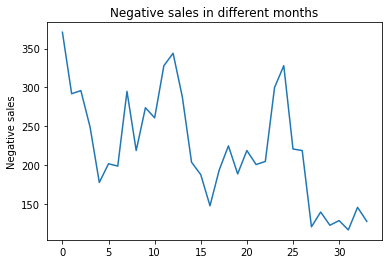

In [ ]:
temp = sales[sales.item_cnt_day < 0][['date_block_num', 'item_cnt_day']].groupby('date_block_num').sum()
plt.plot(temp.index, - temp.item_cnt_day)
plt.ylabel('Negative sales')
plt.title('Negative sales in different months')
plt.show()

There is obvious seasonality(0, 11, 23 - January) in negative sales. So it is probably count of returned items

In [ ]:
print('Zero sales count: ', len(sales[sales.item_cnt_day == 0]))

Zero sales count:  0


So records of *not* selling a particular product are absent. It should be taken into consideration as we want our future model to be able to predict 0 as well.

In [ ]:
sales[['item_price']].describe(percentiles=[.25, .5, .75, .95]).T

count       mean          std  min    25%    50%    75%  \
item_price  2935849.0  890.85321  1729.799683 -1.0  249.0  399.0  999.0   

               95%       max  
item_price  2690.0  307980.0

It looks like 95% of items were sold for less than 2690 RUB considering max price is ~300.000 RUB

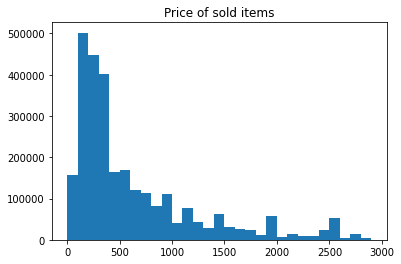

In [ ]:
plt.hist(sales.item_price, bins = list(range(0,3000, 100)))
plt.title('Price of sold items')
plt.show()

Log the price so that it has less variance

In [ ]:
sales['ln_price'] = np.log(sales.item_price + 3)
sales[['ln_price']].describe(percentiles=[.25, .5, .75, .95]).T

count     mean       std       min       25%       50%  \
ln_price  2935849.0  6.17414  1.094868  0.693147  5.529429  5.996452   

               75%       95%      max  
ln_price  6.909753  7.898411  12.6378

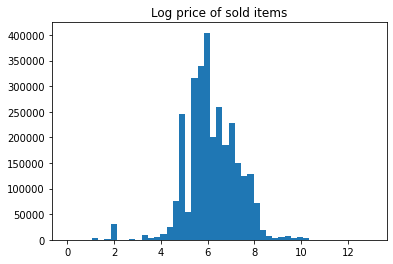

In [ ]:
plt.hist(sales.ln_price, bins = list(np.linspace(0,13,50)))
plt.title('Log price of sold items')
plt.show()

Looks much prettier :)

Look at the distribution of item_cnt_dat

In [ ]:
sales[['item_cnt_day']].describe(percentiles=[.25, .5, .75, .875, .95]).T

count      mean       std   min  25%  50%  75%  87.5%  95%  \
item_cnt_day  2935849.0  1.242641  2.618834 -22.0  1.0  1.0  1.0    1.0  2.0   

                 max  
item_cnt_day  2169.0

It looks like most items were sold by <= 1 in a day and 95% were sold in less or equal than 2, while max count is 2169

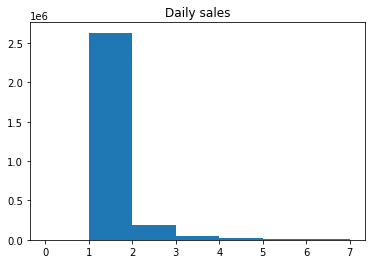

In [ ]:
plt.hist(sales.item_cnt_day, bins = list(range(0,8, 1)))
plt.title('Daily sales')
plt.show()

Top 10 shops, maximum daily count

In [ ]:
temp = sales.groupby('shop_id')[['item_cnt_day']].max().sort_values(['item_cnt_day'], axis=0, ascending=False)
pd.merge(temp.iloc[:10], shops, on = 'shop_id').drop(['shop_id', 'city'], axis = 1)

item_cnt_day                         shop_name
0          2169               Интернет-магазин ЧС
1           637          Цифровой склад 1С-Онлайн
2           502    Москва ТЦ "МЕГА Белая Дача II"
3           501               Москва ТРК "Атриум"
4           405  Москва ТК "Буденовский" (пав.К7)
5           313                   Химки ТЦ "Мега"
6           299            СПб ТК "Невский Центр"
7           288           Москва ТЦ "Семеновский"
8           255              Калуга ТРЦ "XXI век"
9           251            Сургут ТРЦ "Сити Молл"

The maximum was at the Internet store

# **Outliers**

We saw a lot of outliers in count and price columns based on 'describtion' method. Let's examine outliers 

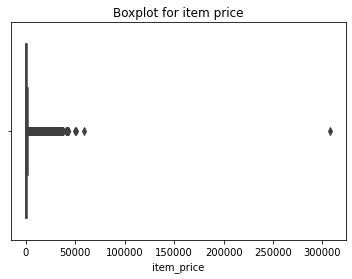

In [ ]:
sns.boxplot(sales.item_price)
plt.title('Boxplot for item price')
plt.show()

As we can see the variance is huge(it does not even look like boxplot) and there are a lot of outliers.
And if look at the most expensive items we'll see that there are only 3 of them

In [ ]:
sales[sales.item_price >= 50000]

date  date_block_num  shop_id  item_id  item_price  \
885138  2013-09-17               8       12    11365     59200.0   
1163158 2013-12-13              11       12     6066    307980.0   
1488135 2014-03-20              14       25    13199     50999.0   

         item_cnt_day   ln_price  
885138              1  10.988728  
1163158             1  12.637800  
1488135             1  10.839621

We already created a ln(price) feature. Let's look at its boxplot

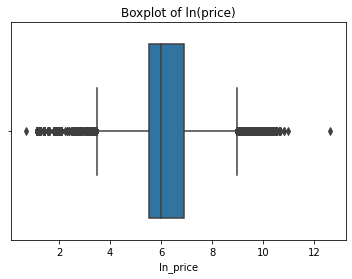

In [ ]:
sns.boxplot(sales.ln_price)
plt.title('Boxplot of ln(price)')
plt.show()

It already looks a lot better even though we still see a lot of outliers

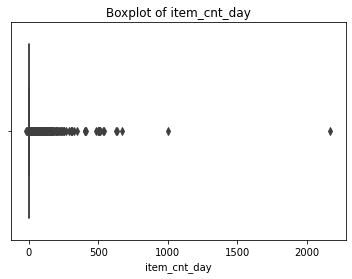

In [ ]:
sns.boxplot(sales.item_cnt_day)
plt.title('Boxplot of item_cnt_day')
plt.show()

In [ ]:
len(sales[sales.item_cnt_day > 2])/len(sales)

0.035737532822703075

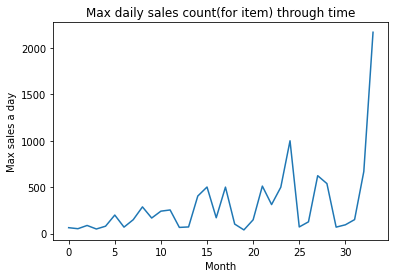

In [ ]:
temp = sales.groupby('date_block_num')['item_cnt_day'].max()
plt.plot(temp.index, temp)
plt.xlabel('Month')
plt.ylabel('Max sales a day')
plt.title('Max daily sales count(for item) through time')
plt.show()

# Merge items with categories

In [ ]:
items_with_categories = pd.merge(items,categories, on = 'item_category_id')

In [ ]:
def plot_items_in_categories(name):
    fig = plt.figure(figsize=(18,10))
    chart = sns.countplot(y=name, data=items_with_categories, palette = 'Paired')
    chart.set(xlabel='items', ylabel='categories')
    plt.title('Number of items in a category')
    plt.show()

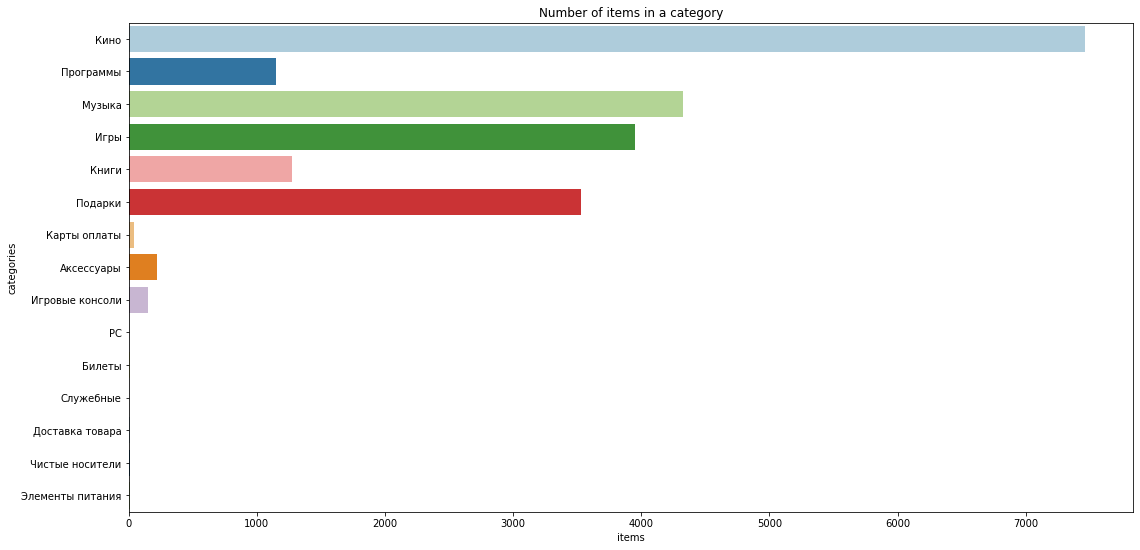

In [ ]:
plot_items_in_categories('cat')

It looks like most items from items dataset are labeled as "Кино". Some categories are represented by a very limited amount of items. Maybe it would make sense to unite them into one category like 'other' for simplification later

Now let's look at amoutn of items in subcategories

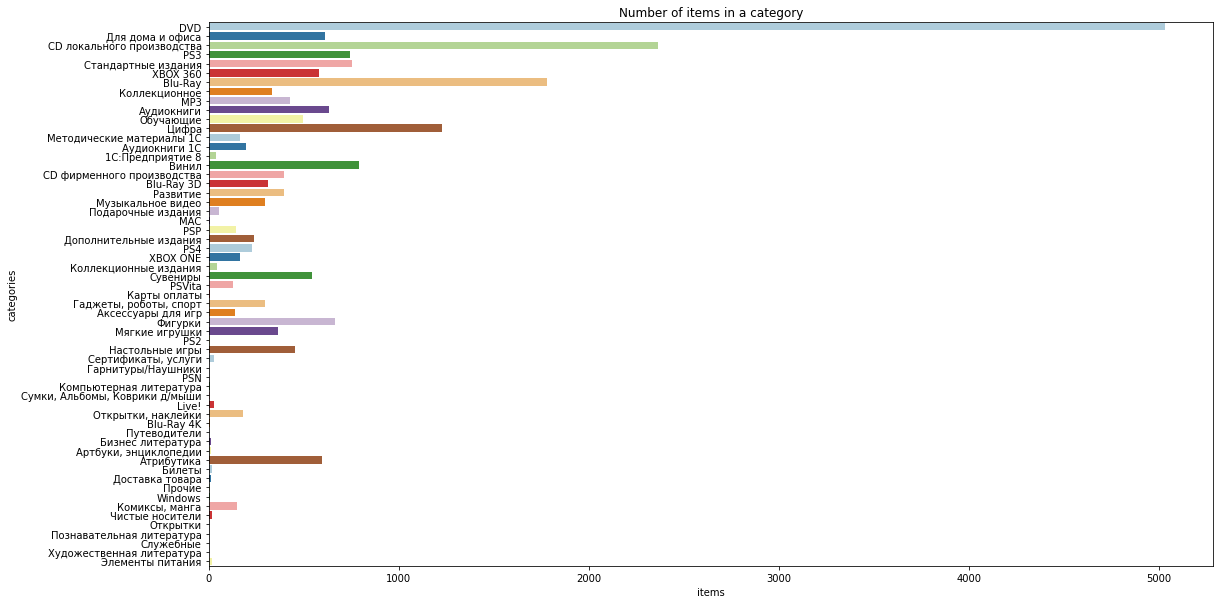

In [ ]:
plot_items_in_categories('sub_cat')

# Total sells in a city

In [ ]:
sales_shop = pd.merge(sales,shops, on = 'shop_id')
cities_total = sales_shop.groupby('city')['item_cnt_day'].sum()

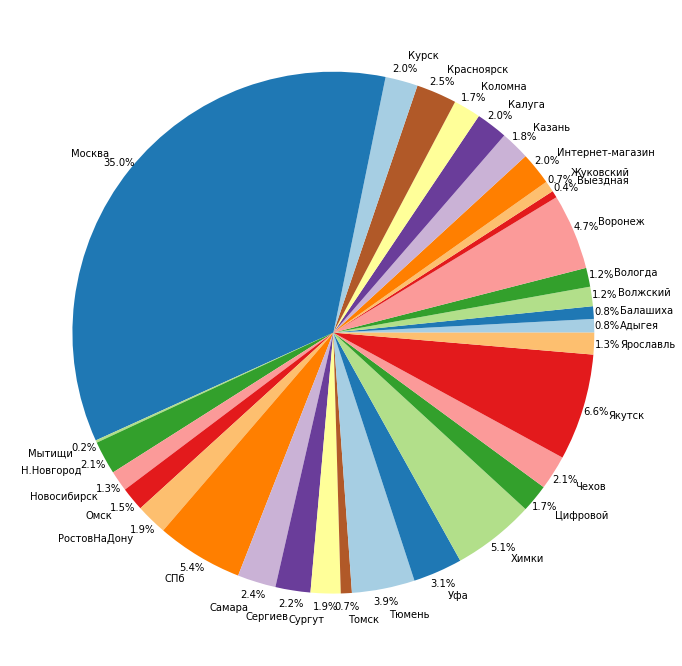

In [ ]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cities_total)]
plt.pie(cities_total,
        labels = cities_total.index, 
        autopct = '%0.1f%%', 
        pctdistance = 1.05, 
        labeldistance = 1.1,
        colors = colors)
plt.show()

As you can see from the pieplot most of the items were sold in Moscow. But Moscow also has much more shops than other cities. But it is important to keep in mind that it is possible that some shops were opened later(or closed before the end of observation). Let's look at the sales in shops and look at the dates of the fisrt and last sold item in shops and how these dates align with observation period

# Total sells in shops

In [ ]:
shops_total = sales_shop.groupby('shop_name')['item_cnt_day'].sum()

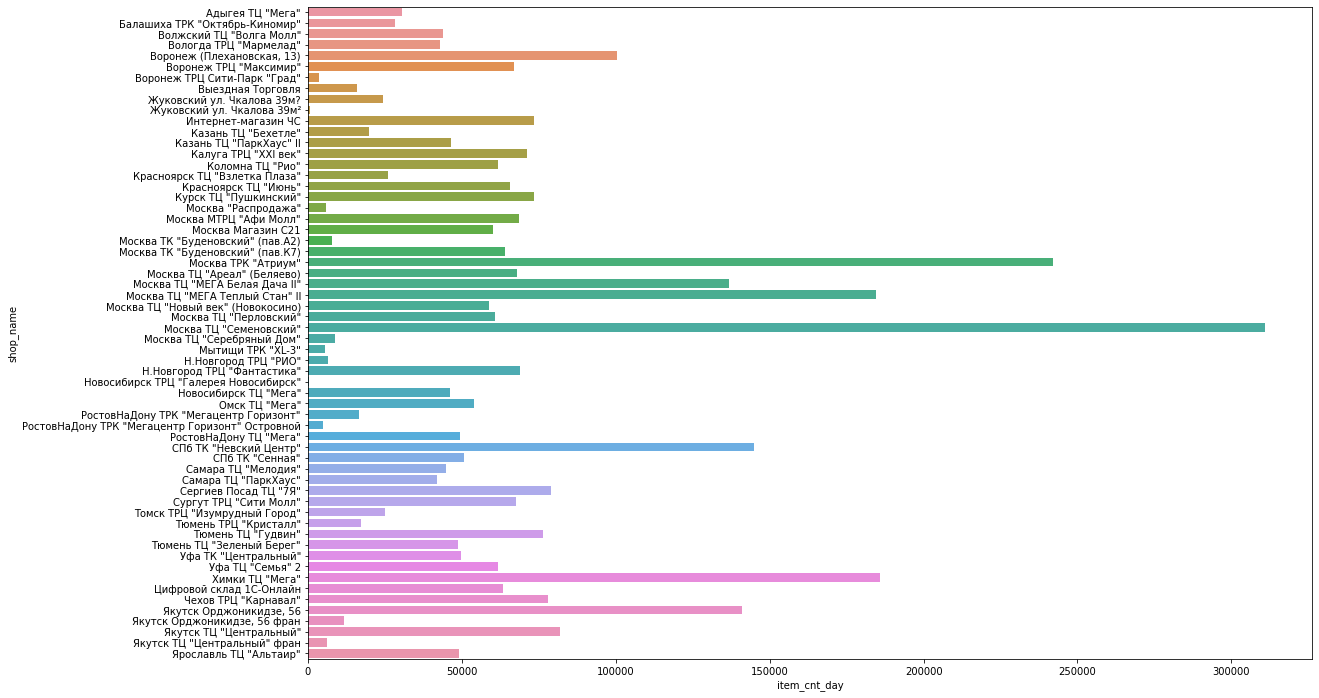

In [ ]:
fig = plt.figure(figsize=(18,12))
chart = sns.barplot(x = shops_total, y = shops_total.index)
plt.show()

# Shops opened/closed

In [ ]:
first_date_shop = pd.DataFrame(sales.groupby('shop_id')['date'].min()).reset_index([0]).sort_values('date')
last_date_shop = pd.DataFrame(sales.groupby('shop_id')['date'].max()).reset_index([0]).sort_values('date')

In [ ]:
last_date_shop[last_date_shop.date < datetime(2015, 10, 10)].T

0                    1                    8   \
shop_id                    0                    1                    8   
date     2013-02-28 00:00:00  2013-02-28 00:00:00  2013-04-01 00:00:00   

                          23                   32                   13  \
shop_id                   23                   32                   13   
date     2013-04-28 00:00:00  2013-07-03 00:00:00  2014-08-09 00:00:00   

                          17                   43                   40  \
shop_id                   17                   43                   40   
date     2015-01-18 00:00:00  2015-01-25 00:00:00  2015-01-29 00:00:00   

                          30                   11                   54  \
shop_id                   30                   11                   54   
date     2015-02-18 00:00:00  2015-02-28 00:00:00  2015-04-23 00:00:00   

                          33                   29                   51  \
shop_id                   33                   29                   51   
date     2015-04-24 00:00:00  2015-05-28 00:00:00  2015-09-28 00:00:00   

                          27                   20  
shop_id                   27                   20  
date     2015-09-30 00:00:00  2015-10-04 00:00:00

We see that there are shops that were closed before the end of observation 2015.10. Save there indexes to look at them later. Maybe we will be able to identify patterns which led to closing

In [ ]:
closed_shops = last_date_shop[last_date_shop.date < datetime(2015, 10, 30)].shop_id

In [ ]:
pd.merge(first_date_shop[first_date_shop.date > datetime(2013, 1, 15)], shops, on='shop_id')

shop_id       date                                        shop_name  \
0         5 2013-02-08                           Вологда ТРЦ "Мармелад"   
1        58 2013-03-01                          Якутск ТЦ "Центральный"   
2        57 2013-03-01                          Якутск Орджоникидзе, 56   
3        55 2013-05-01                         Цифровой склад 1С-Онлайн   
4        17 2013-06-06                    Красноярск ТЦ "Взлетка Плаза"   
5         9 2013-10-03                                Выездная Торговля   
6        49 2013-12-25                            Тюмень ТРЦ "Кристалл"   
7        40 2014-03-01  РостовНаДону ТРК "Мегацентр Горизонт" Островной   
8        39 2014-03-01            РостовНаДону ТРК "Мегацентр Горизонт"   
9        48 2014-04-25                     Томск ТРЦ "Изумрудный Город"   
10       34 2014-07-31                             Н.Новгород ТРЦ "РИО"   
11       33 2014-08-29                                Мытищи ТРК "XL-3"   
12       20 2014-10-02                              Москва "Распродажа"   
13       11 2015-02-01                       Жуковский ул. Чкалова 39м²   
14       36 2015-10-18            Новосибирск ТРЦ "Галерея Новосибирск"   

            city  
0        Вологда  
1         Якутск  
2         Якутск  
3       Цифровой  
4     Красноярск  
5       Выездная  
6         Тюмень  
7   РостовНаДону  
8   РостовНаДону  
9          Томск  
10    Н.Новгород  
11        Мытищи  
12        Москва  
13     Жуковский  
14   Новосибирск

We see that there are shops that were opened later which explains the difference in total sales within a city. It looks like most shops in Moscow were already opened in 2013, while shops in other cities were opened much later

# Which month is the most selling

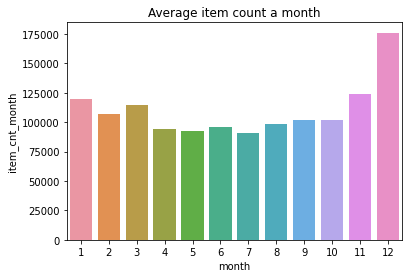

In [ ]:
m = [3] * 10 + [2] * 2
mean_month = pd.DataFrame(sales.groupby(sales.date.dt.month)['item_cnt_day'].sum()/ m).reset_index(level = [0])
mean_month.columns = ['month', 'item_cnt_month']
sns.barplot(x='month', y='item_cnt_month', data=mean_month)
plt.title('Average item count a month')
plt.show()

December is clearly the 'leader', which is supposably due to major holidays such as Christmas and New Year. It will make sence to look at the correlation between sales in different years for each month( sep 2014 - sep 2015 for example)

# Count months for each item

We want to look how long each item was for sale

In [ ]:
month_count_item = pd.DataFrame(sales.groupby(['item_id', 'date_block_num'])['item_cnt_day'].sum()).reset_index(level = [0,1])
month_count_item.columns = ['item_id', 'date_block_num', 'item_cnt_month']

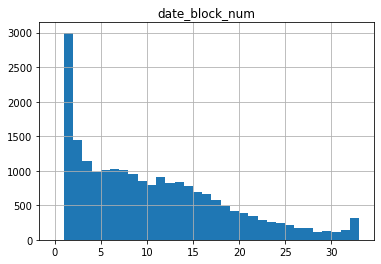

In [ ]:
item_month = pd.DataFrame(month_count_item.groupby('item_id')['date_block_num'].count())
item_month.hist(bins = list(range(34)))
plt.show()

As we can see most items were sold only for a short period of time. Let's see if there are items which were not sold at all

In [ ]:
len(items) - len(item_month)

363

363 items were not sold at all. These are the new items which are presented only in test set. We need to be careful with these items. We know their category and the shop but we do not know the price of these items, so we have to estimate it somehow. It will be done later

# Fill missing months with 0


Let's create a full empty dataset and merge it with sales aggregated by item shop and date_block_num. Thus we create dataset with all of the combinations of item - shop - month

In [ ]:
it_index = []
sh_index = []
sh_len = len(shops)
date = []
for i in range(len(items)):
    it_index += [i]*(34 * sh_len)
    sh_index += list(range(sh_len))* 34
    for j in range(34):
        date += [j] * sh_len

In [ ]:
data = pd.merge(
    pd.DataFrame({
    'item_id' : it_index,
    'shop_id': sh_index,
    'date_block_num' : date
}), pd.DataFrame(sales.groupby(['item_id','shop_id', 'date_block_num'])['item_cnt_day'].sum()).reset_index(level = [0,1,2]),
 how = 'left', on = ['item_id','shop_id', 'date_block_num'] )
data = data.fillna(0)
data.columns = ['item_id', 'shop_id', 'date_block_num', 'item_cnt_month']
data.sample(10)

item_id  shop_id  date_block_num  item_cnt_month
24442602    11981       42              22             0.0
75405          36       45              32             0.0
42326670    20748       30              12             0.0
38898638    19067       38              32             0.0
24929006    12220       26               3             0.0
29293341    14359       21              16             0.0
30688560    15043        0              14             0.0
6800314      3333       34              16             0.0
18461906     9049       26              32             0.0
20535373    10066       13              12             0.0

Now check if the merge was correct

In [ ]:
data.groupby(['item_id', 'shop_id'])[['date_block_num']].nunique().describe().T

count  mean  std   min   25%   50%   75%   max
date_block_num  1330200.0  34.0  0.0  34.0  34.0  34.0  34.0  34.0

In [ ]:
data.groupby(['item_id','date_block_num'])[['shop_id']].nunique().describe().T

count  mean  std   min   25%   50%   75%   max
shop_id  753780.0  60.0  0.0  60.0  60.0  60.0  60.0  60.0

In [ ]:
data.groupby(['shop_id','date_block_num'])[['item_id']].nunique().describe().T

count     mean  std      min      25%      50%      75%      max
item_id  2040.0  22170.0  0.0  22170.0  22170.0  22170.0  22170.0  22170.0

Everything looks fine

In [ ]:
it_index = 0; sh_index = 0; date = 0

Now let's merge data with the mean price for ['item_id', 'shop_id', 'date_block_num']

In [ ]:
mean_price = sales.groupby(['item_id', 'shop_id', 'date_block_num'])['item_price'].mean().reset_index([0,1,2])
data = pd.merge(data, mean_price, on = ['item_id', 'shop_id', 'date_block_num'], how = 'left')

In [ ]:
data.isna().sum()

item_id                  0
shop_id                  0
date_block_num           0
item_cnt_month           0
item_price        43617676
dtype: int64

In [ ]:
check = sales.groupby(['item_id', 'shop_id', 'date_block_num'])[['item_price']].mean()
check = check.groupby(['item_id', 'date_block_num'])[['item_price']].std().describe([.25,.75,.85]).T
check

count       mean        std  min  25%  50%       75%  \
item_price  168013.0  28.043297  85.888485  0.0  0.0  0.0  30.19806   

                  85%          max  
item_price  51.205629  6830.053294

We see a lot of empty values and the variation of price in different shops is rather big. So we'll calculate mean price for each item + month and then do the forward fill to fill the empty values. 

In [ ]:
mean_price_month = sales.groupby(['item_id', 'date_block_num'])[['item_price']].mean().reset_index([0,1])
mean_price_month.columns = ['item_id', 'date_block_num','mean_item_price']

In [ ]:
it_index = []
date = []
for i in range(len(items)):
    it_index += [i]*(34)
    date += list(range(34))

In [ ]:
mean_price_month = pd.merge(mean_price_month, pd.DataFrame({
    'item_id' : it_index,
    'date_block_num' : date}), on = ['item_id', 'date_block_num'], how = 'right')
it_index = 0
date = 0

In [ ]:
mean_price_month.mean_item_price = mean_price_month.groupby('item_id').mean_item_price.fillna(method = 'ffill') 
mean_price_month.mean_item_price = mean_price_month.groupby('item_id').mean_item_price.fillna(method = 'bfill') 

In [ ]:
data = pd.merge(data, mean_price_month, on = ['item_id', 'date_block_num'], how = 'left' )
data.item_price = data.item_price.fillna(data['mean_item_price'])
data = data.drop(['mean_item_price'], axis = 1)
data.isna().sum()

item_id                0
shop_id                0
date_block_num         0
item_cnt_month         0
item_price        740520
dtype: int64

This are the items that were not sold at all (new items) (363 * 34 * 64)
We'll merge all the datasets together and then fill the price with the mean price in a category

In [ ]:
data.item_id = data.item_id.astype(np.int16)
data.shop_id = data.shop_id.astype(np.int8)
data.date_block_num = data.date_block_num.astype(np.int8)
data.item_cnt_month = data.item_cnt_month.astype(np.int32)
data.item_price = data.item_price.astype(np.float32)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45226800 entries, 0 to 45226799
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   item_id         int16  
 1   shop_id         int8   
 2   date_block_num  int8   
 3   item_cnt_month  int32  
 4   item_price      float32
dtypes: float32(1), int16(1), int32(1), int8(2)
memory usage: 862.6 MB


# Merge all

In [ ]:
data = pd.merge(data, shops, on = 'shop_id')
data = pd.merge(data, items, on = 'item_id')
data = pd.merge(data, categories, on = 'item_category_id' )
len(data)

45226800

In [ ]:
data[data.item_cnt_month < 0] = 0

In [ ]:
data.item_category_id = data.item_category_id.astype(np.int8)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45226800 entries, 0 to 45226799
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   item_id             int16  
 1   shop_id             int8   
 2   date_block_num      int8   
 3   item_cnt_month      int32  
 4   item_price          float32
 5   shop_name           object 
 6   city                object 
 7   item_name           object 
 8   item_category_id    int8   
 9   item_category_name  object 
 10  cat                 object 
 11  sub_cat             object 
dtypes: float32(1), int16(1), int32(1), int8(3), object(6)
memory usage: 2.9+ GB


Fill price for new items with the mean in a subcategory

In [ ]:
data['item_price'] = data['item_price'].fillna(data.groupby('sub_cat')['item_price'].transform('mean'))

In [ ]:
data.isna().sum()

item_id               0
shop_id               0
date_block_num        0
item_cnt_month        0
item_price            0
shop_name             0
city                  0
item_name             0
item_category_id      0
item_category_name    0
cat                   0
sub_cat               0
dtype: int64

Now there are no missing values

In [ ]:
data['ln_price'] = np.log(data.item_price + 3)

# Most selling categories

In [ ]:
cat_total = data.groupby('cat')['item_cnt_month'].sum()

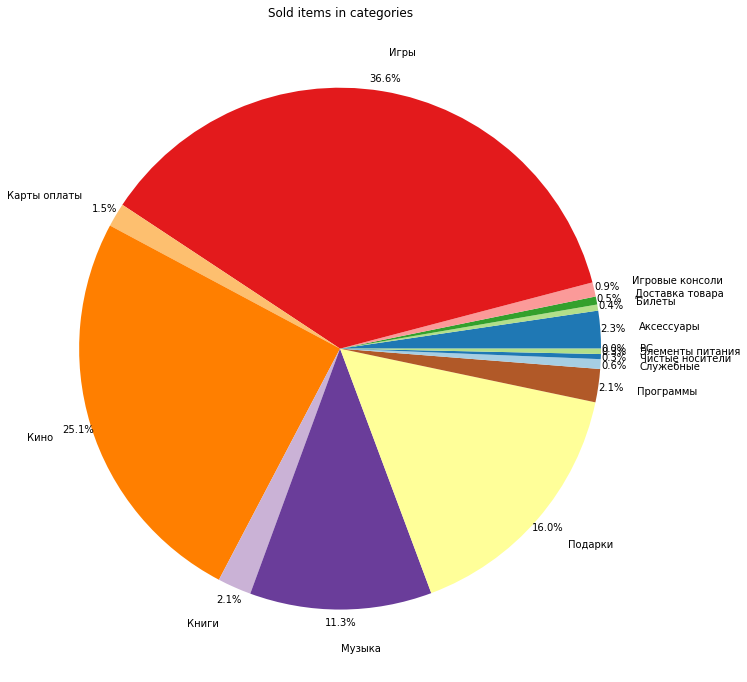

In [ ]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cat_total)]
plt.pie(cat_total, 
        labels = cat_total.index,
        pctdistance = 1.05, 
        labeldistance = 1.15, 
        autopct = '%0.1f%%', 
        colors = colors)
plt.title('Sold items in categories')
plt.show()

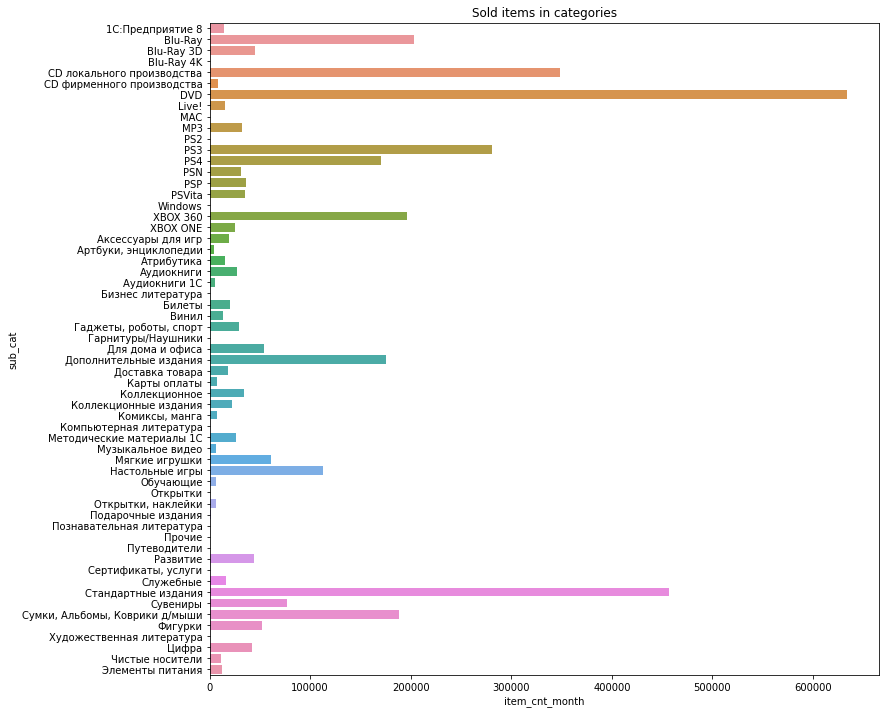

In [ ]:
cat_total = data.groupby('sub_cat')['item_cnt_month'].sum()
plt.figure(figsize=(12,12))
sns.barplot(x = cat_total, y = cat_total.index)
plt.title('Sold items in categories')
plt.show()

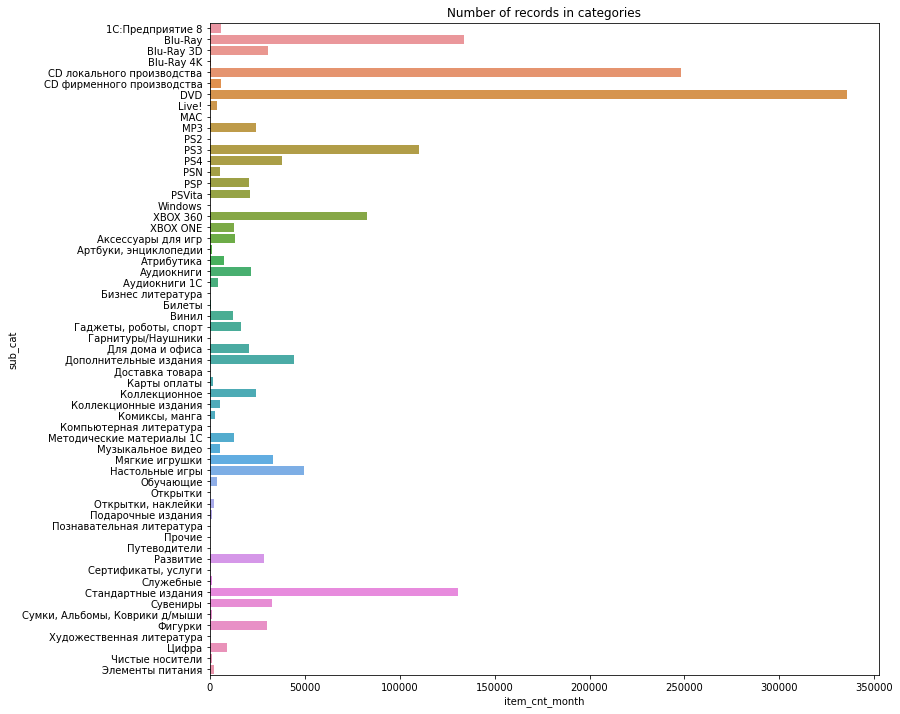

In [ ]:
cat_total = data[data.item_cnt_month > 0].groupby('sub_cat')['item_cnt_month'].count()
plt.figure(figsize=(12,12))
sns.barplot(x = cat_total, y = cat_total.index)
plt.title('Number of records in categories')
plt.show()

Wee see that some categories are presented with a small amount of records. It is important to keep this in mind as it might cause overfitting

# Min, mean and max ln(price) 

In [ ]:
def min_max_cat(name):
    cat_price = data.groupby(name)['ln_price'].describe()
    cat_price = cat_price[['min','mean', 'max']]
    cat_price = cat_price.reset_index(level=[0])
    return cat_price

In [ ]:
cat_price = min_max_cat('cat')
sub_cat_price = min_max_cat('sub_cat')

In [ ]:
cats = pd.unique(categories.cat)
sub_cats = pd.unique(categories.sub_cat)

In [ ]:
def plot_cats(cat_price, categ, rows):
    plt.subplots_adjust(wspace = 2)
    for i in range(len(categ)):
        plt.subplot(rows,len(categ)//(rows - 1), i+1)
        sns.barplot(x = cat_price.columns[1:], y = cat_price.iloc[i,1:])
        plt.title(cat_price.iloc[i,0])
    plt.show()

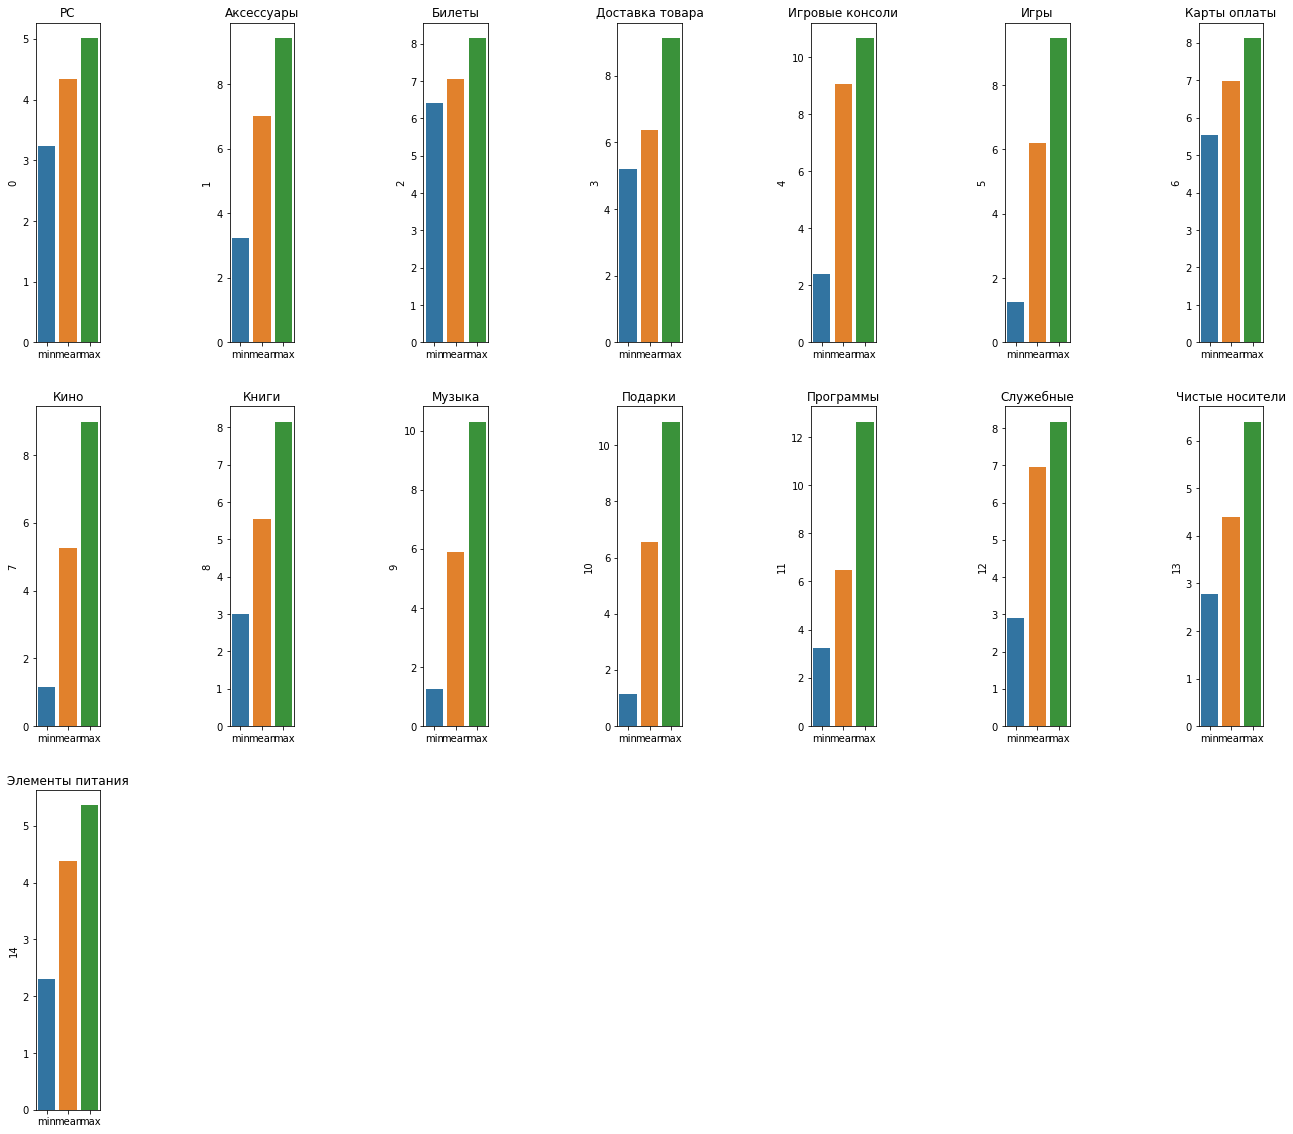

In [ ]:
plt.figure(figsize=(22,20))
plot_cats(cat_price, cats, 3)

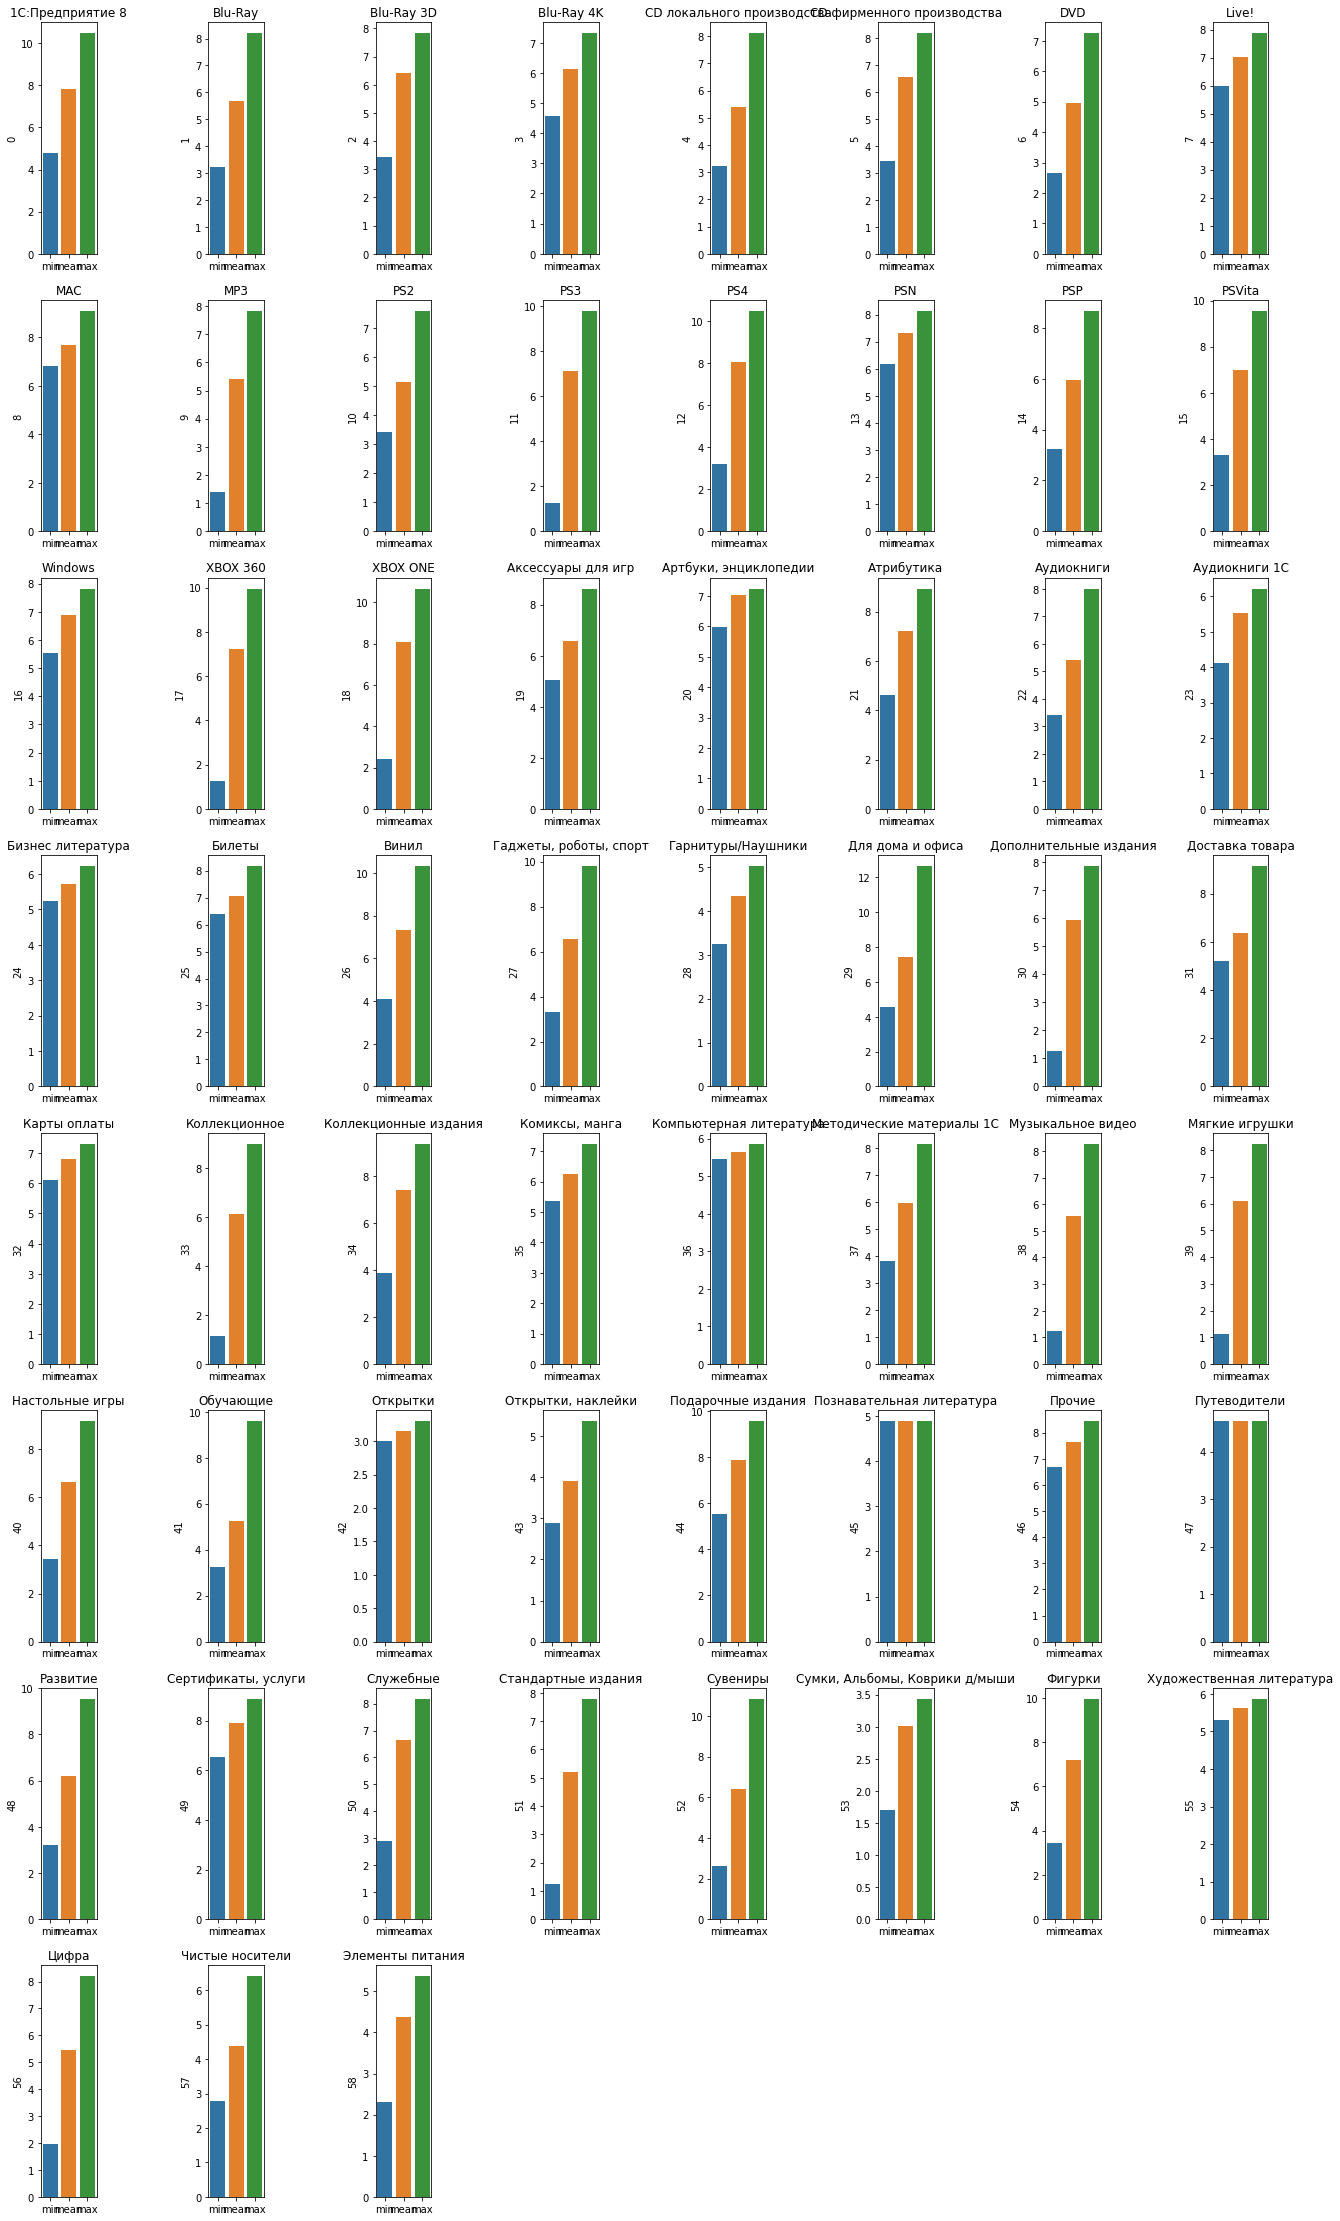

In [ ]:
plt.figure(figsize=(22,40))
plot_cats(sub_cat_price,sub_cats, 8)

Ideally we would like to see that ln_price in categories 

# How mean price affects total count

In [ ]:
item_cnt = pd.DataFrame(data[(data.date_block_num >= 24)&(data.item_cnt_month > 0)].groupby('item_id')['item_cnt_month'].sum()).reset_index(level = [0])
item_cnt.columns = ['item_id', 'item_cnt_month']

In [ ]:
item_price_mean = pd.DataFrame(data[(data.date_block_num >= 24)&(data.item_cnt_month > 0)].groupby('item_id')['item_price'].mean()).reset_index(level = [0])
temp = pd.merge(item_cnt, item_price_mean, on = 'item_id')
temp.columns = ['item_id', 'item_cnt_total', 'item_price']

In [ ]:
temp.drop(['item_id'], axis=1).corr()

item_cnt_total  item_price
item_cnt_total        1.000000    0.014616
item_price            0.014616    1.000000

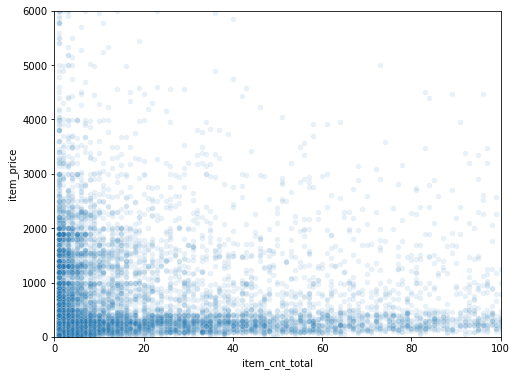

In [ ]:
plt.figure(figsize=(8,6))
sc = sns.scatterplot(x = temp.item_cnt_total, y = temp.item_price, x_bins = [0, 50, 100], alpha = 0.1, s = 30)
sc.set_xlim(left=0, right=100)
sc.set_ylim(bottom=0, top=6000);

There is no correlation between sales and price, however we see that items with low prices are more likely to be sold in bigger amounts than items with high prices

# Total sells through time

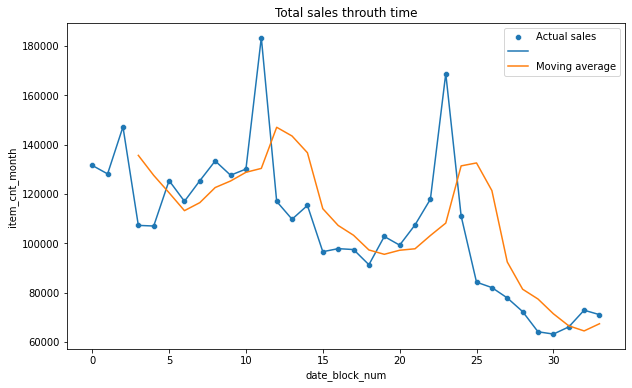

In [ ]:
temp = data.groupby('date_block_num')[['item_cnt_month']].sum()
temp.columns = ['item_cnt_month']
temp['rolling'] = temp.item_cnt_month.shift(1).rolling(3).mean()
plt.figure(figsize=(10,6))
sns.scatterplot(y = temp.item_cnt_month ,x = temp.index)
plt.plot(temp.index, temp)
plt.title('Total sales throuth time')
plt.legend(['Actual sales', '','Moving average'])
plt.show()

We see that there are extremums in December(because of major holidays) and sales tend to decrease while some shops are closing 

# Dollar influence

We want see if adding new feature as dollar exchange rate can explain some changes in prices and or sales

In [ ]:
price_time_mean = data.groupby('date_block_num')['item_price'].mean()
price_time_mean = pd.DataFrame(price_time_mean).reset_index(level=[0])

Use manually collected info

In [ ]:
rub = pd.read_csv('rub.csv').reset_index(level=[0])
rub.rub = [float(x.split(' ')[0]) for x in rub.rub]
rub.columns=['date_block_num', 'rub']

In [ ]:
data_month = pd.DataFrame(data.groupby('date_block_num')['item_cnt_month'].sum())
data_month.columns = ['item_cnt_month']
data_month = data_month.reset_index([0])
a = pd.merge(data_month, rub, on = 'date_block_num')
b = pd.merge(a, price_time_mean)

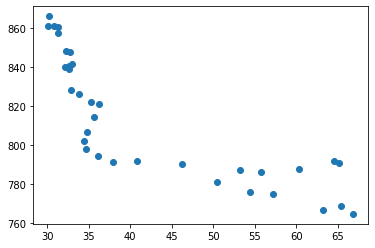

In [ ]:
plt.scatter(rub.rub, price_time_mean.item_price)
plt.show()

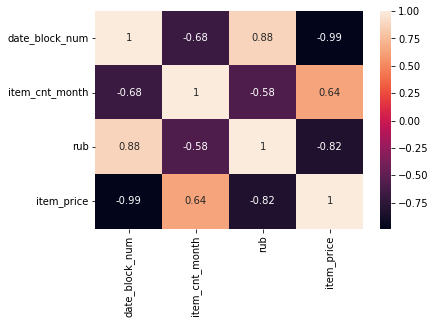

In [ ]:
sns.heatmap(b.corr(), annot=True)

In [ ]:
cat_count = data.groupby(['sub_cat', 'date_block_num'])[['item_cnt_month']].sum().reset_index([0,1]).fillna(0)
temp = data.groupby(['sub_cat', 'date_block_num'])[['item_price']].mean().reset_index([0,1])

In [ ]:
cat_count = pd.merge(cat_count, temp, on = ['date_block_num', 'sub_cat'])
cat_count = cat_count.groupby('sub_cat')

In [ ]:
for i, c in enumerate(sub_cats):
    t = cat_count.get_group(c)
    t = pd.merge(t,rub, on = 'date_block_num', how = 'right')
    print(c)
    print(t.corr().fillna(0))
    print()

Гарнитуры/Наушники
                date_block_num  item_cnt_month  item_price       rub
date_block_num        1.000000       -0.480916         0.0  0.882056
item_cnt_month       -0.480916        1.000000         0.0 -0.293191
item_price            0.000000        0.000000         0.0  0.000000
rub                   0.882056       -0.293191         0.0  1.000000

PS2
                date_block_num  item_cnt_month  item_price       rub
date_block_num        1.000000       -0.406924         0.0  0.882056
item_cnt_month       -0.406924        1.000000         0.0 -0.235068
item_price            0.000000        0.000000         0.0  0.000000
rub                   0.882056       -0.235068         0.0  1.000000

PS3
                date_block_num  item_cnt_month  item_price       rub
date_block_num        1.000000       -0.720463   -0.993737  0.882056
item_cnt_month       -0.720463        1.000000    0.688976 -0.626287
item_price           -0.993737        0.688976    1.000000 -0.856233
rub  

# Mean price in categories through time

In [ ]:
m = pd.DataFrame({'date_block_num' : list(range(34))})

In [ ]:
def plot_cat_time(cat_time, cats, name, cat_name, count = False):
    for i, c in enumerate(cats):
        t = cat_time[cat_time[cat_name] == c]
        t['rolling_avg2'] = t[name].rolling(2).mean()
        t['rolling_avg4'] = t[name].rolling(4).mean()
        plt.subplot(len(cats)//2 + 1,2, i+1)
        X = t.date_block_num.tolist()
        Y = t[name].tolist()
        sns.scatterplot(x = X, y = Y)
        plt.plot(X, Y)
        
        if count:
            text = t.item_id.tolist()
            for i in range(0,len(t),2):
                plt.annotate(text[i], (X[i], Y[i]+2), fontsize = 10)
        sns.lineplot( x = 'date_block_num', y = 'rolling_avg2', data = t)
        sns.lineplot( x = 'date_block_num', y = 'rolling_avg4', data = t)
        plt.legend(['Actual', 'Rolling_average2', 'Rolling_average4'])
        plt.ylabel('sales')
        plt.title(c)

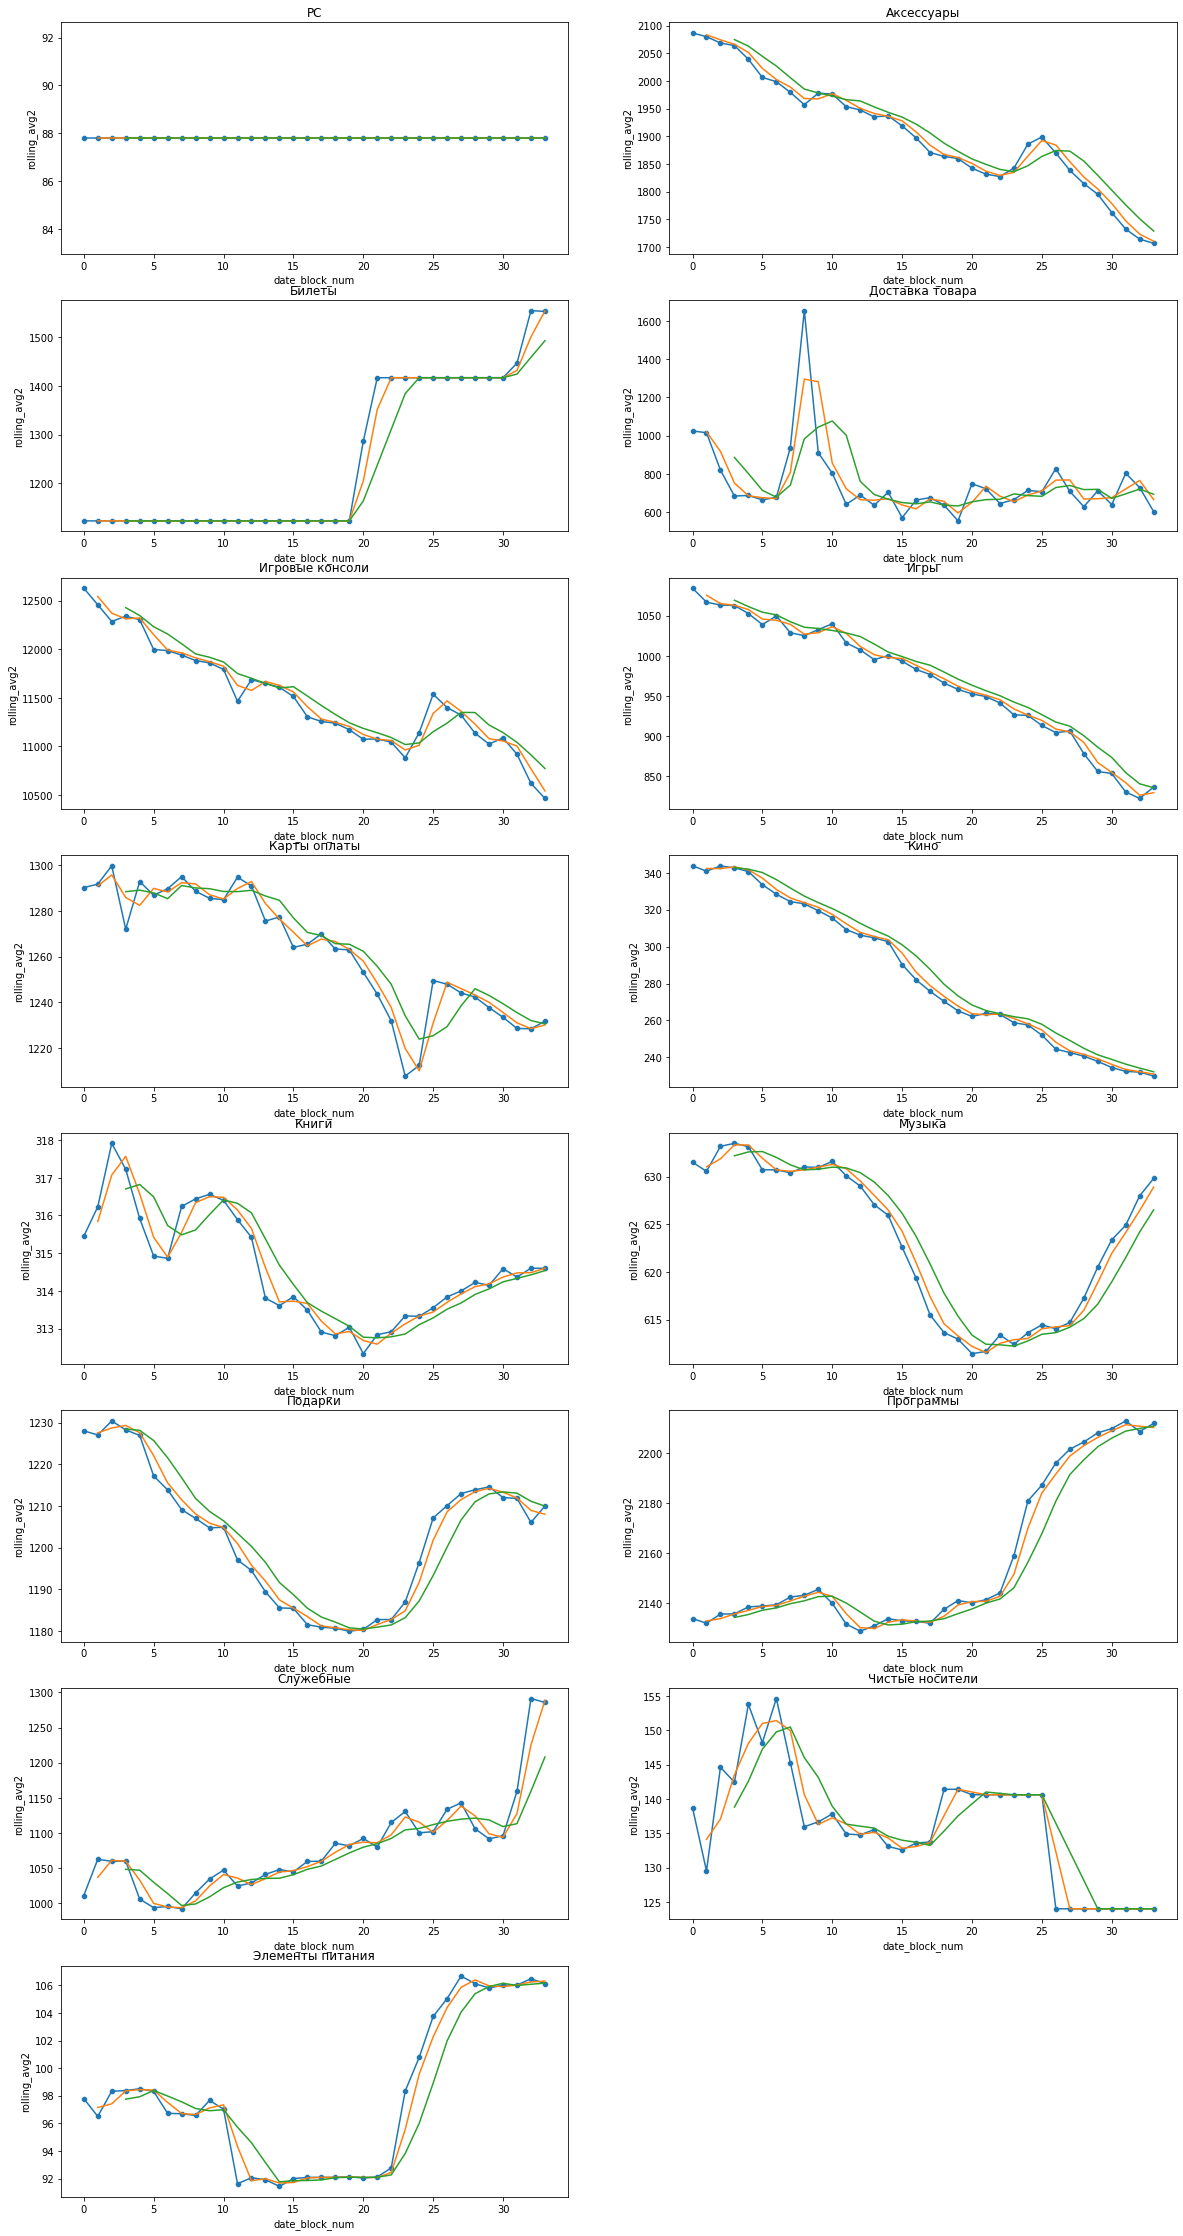

In [ ]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_price'].mean()).reset_index(level=[0,1])
item_count = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_id'].nunique()).reset_index(level=[0,1])
cat_time = pd.merge(cat_time, item_count, on = ['cat','date_block_num'])
plt.figure(figsize=(20,40))
plot_cat_time(cat_time, cats, 'item_price', 'cat')

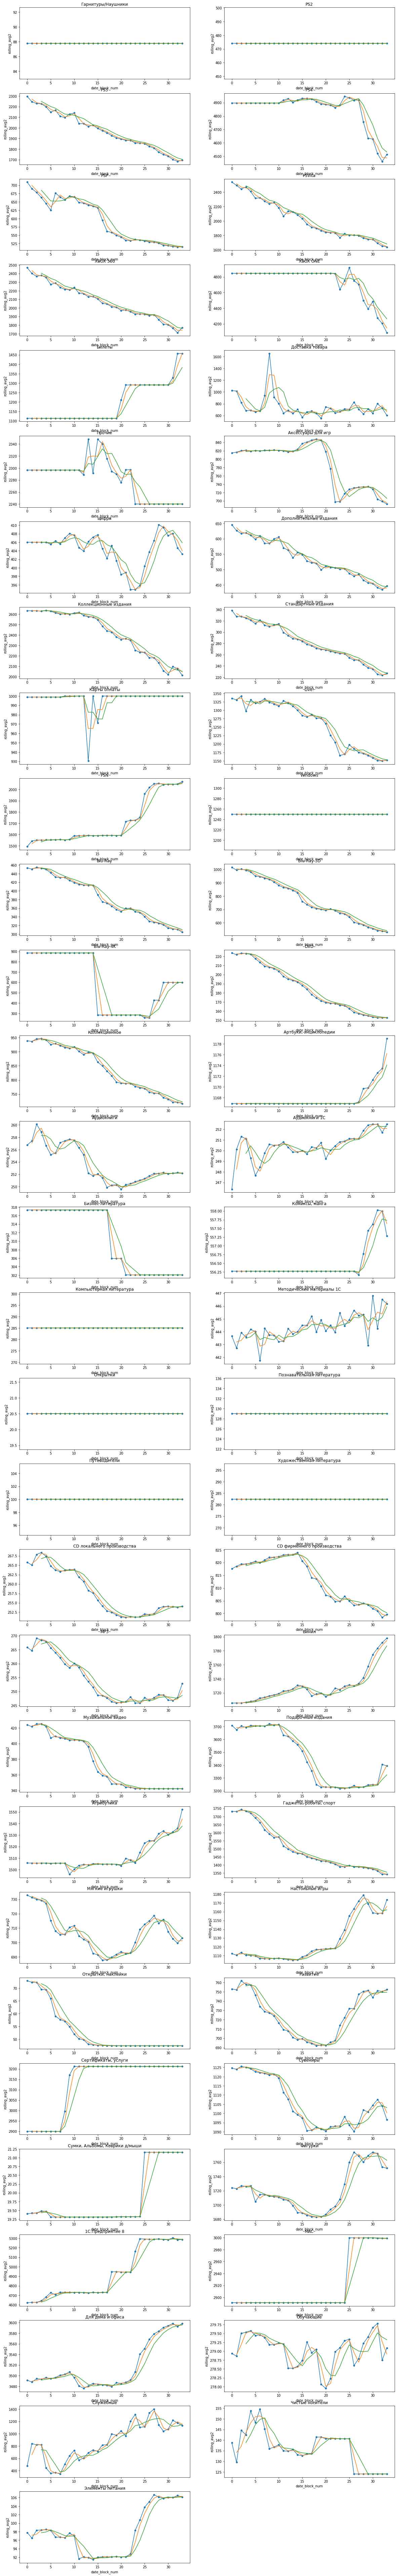

In [ ]:
cat_time = pd.DataFrame(data.groupby(['sub_cat','date_block_num'])['item_price'].mean()).reset_index(level=[0,1])
item_count = pd.DataFrame(data.groupby(['sub_cat','date_block_num'])['item_id'].nunique()).reset_index(level=[0,1])
cat_time = pd.merge(cat_time, item_count, on = ['sub_cat','date_block_num'])
plt.figure(figsize=(20,140))
plot_cat_time(cat_time, sub_cats, 'item_price', 'sub_cat')

**In some categories average price decreases probably due to addition of new cheaper items**

# item_count_month in categories through time

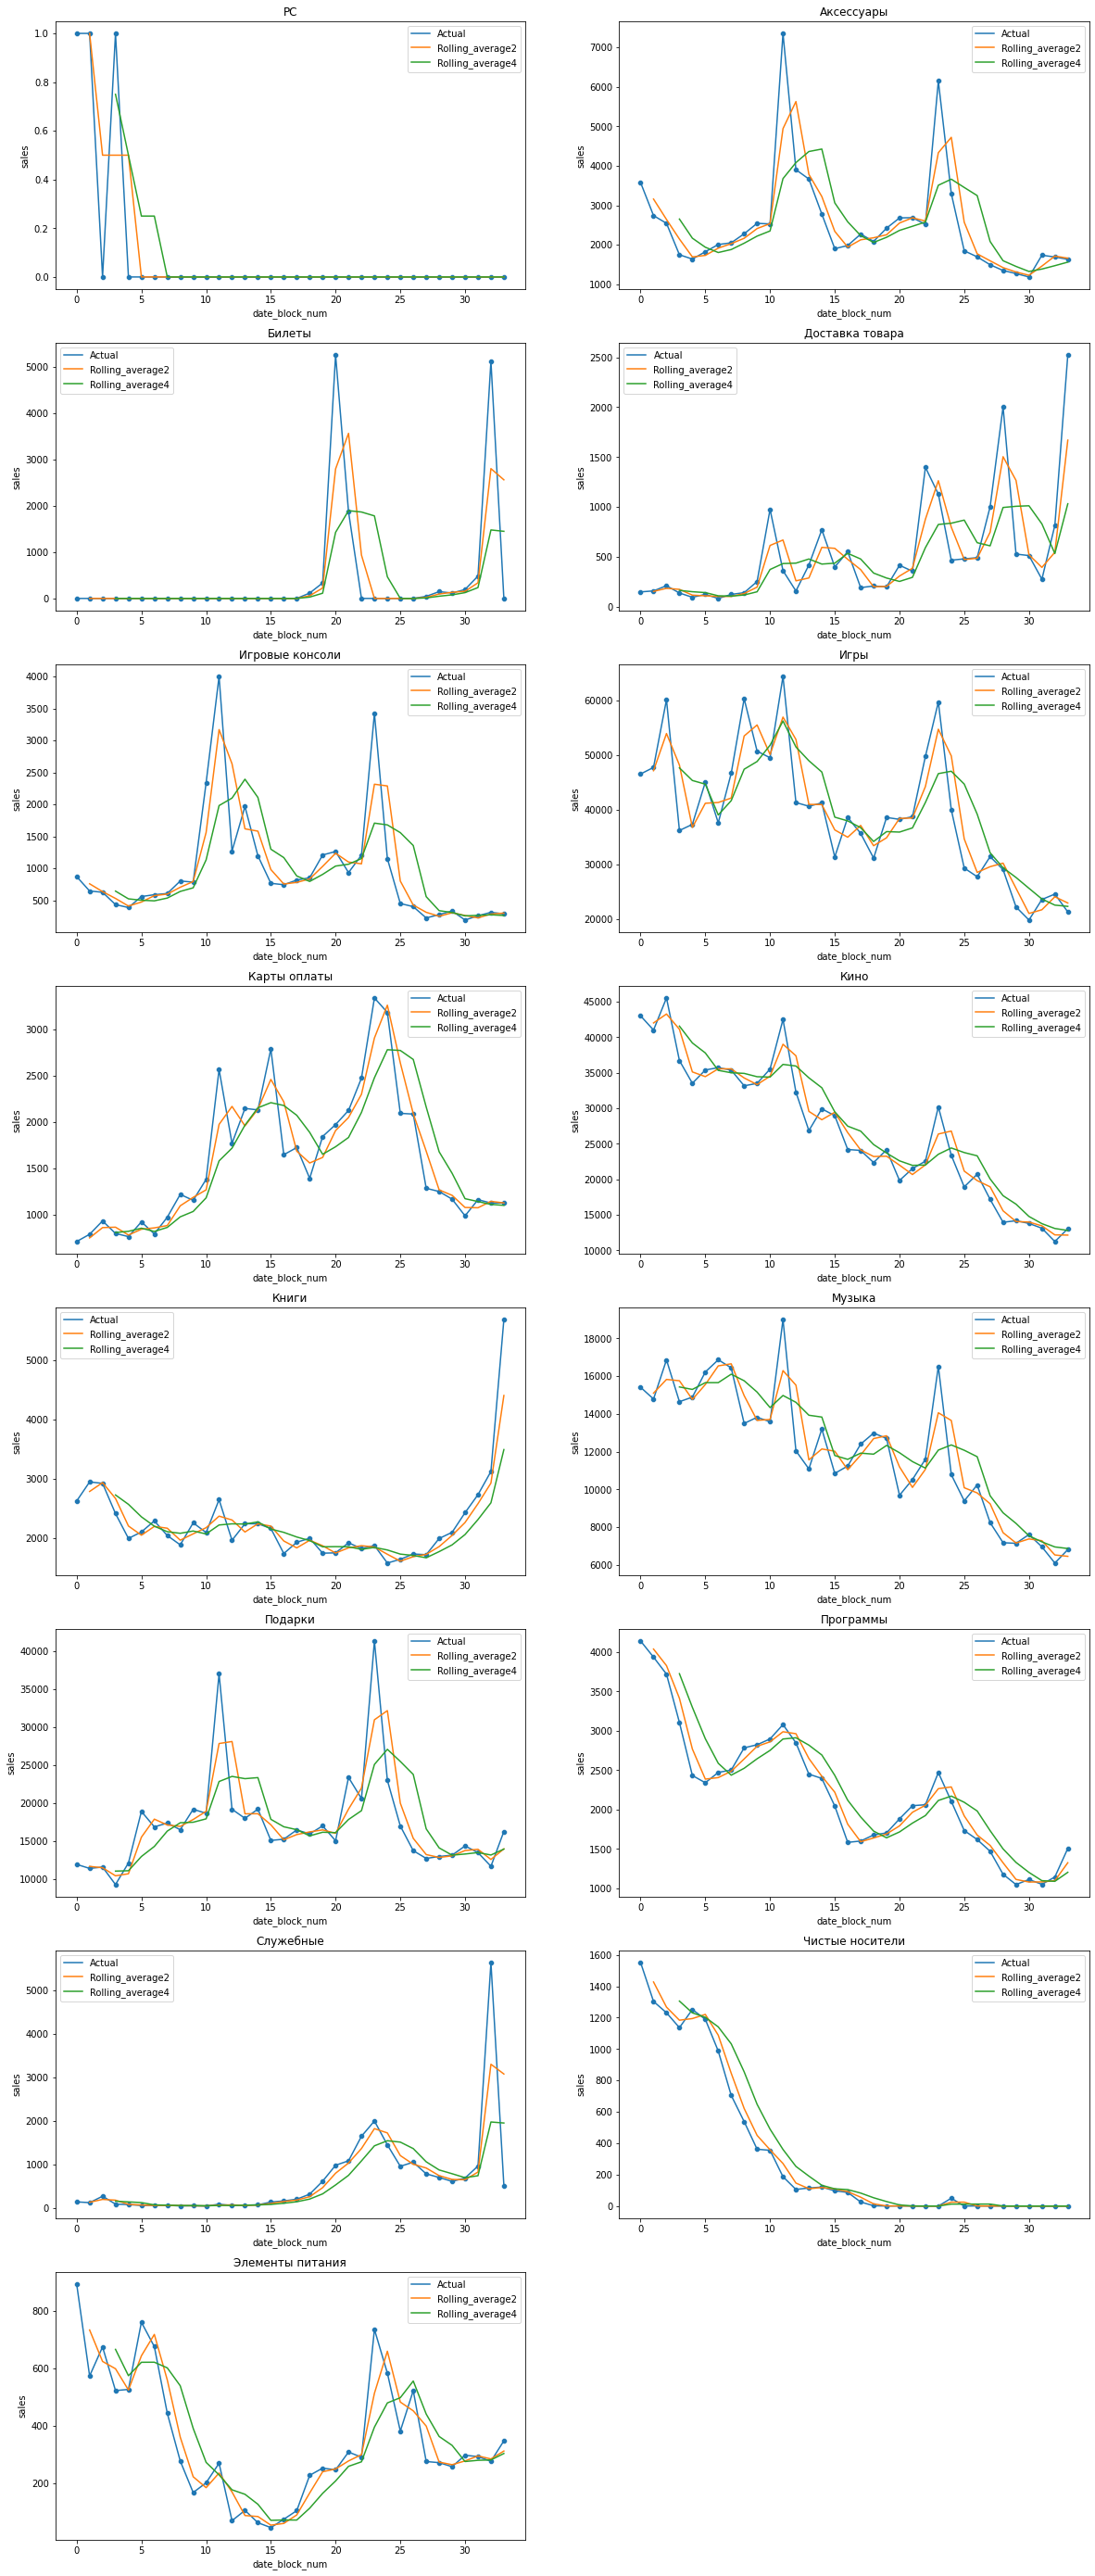

In [ ]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,50))
plot_cat_time(cat_time, cats, 'item_cnt_month', 'cat')

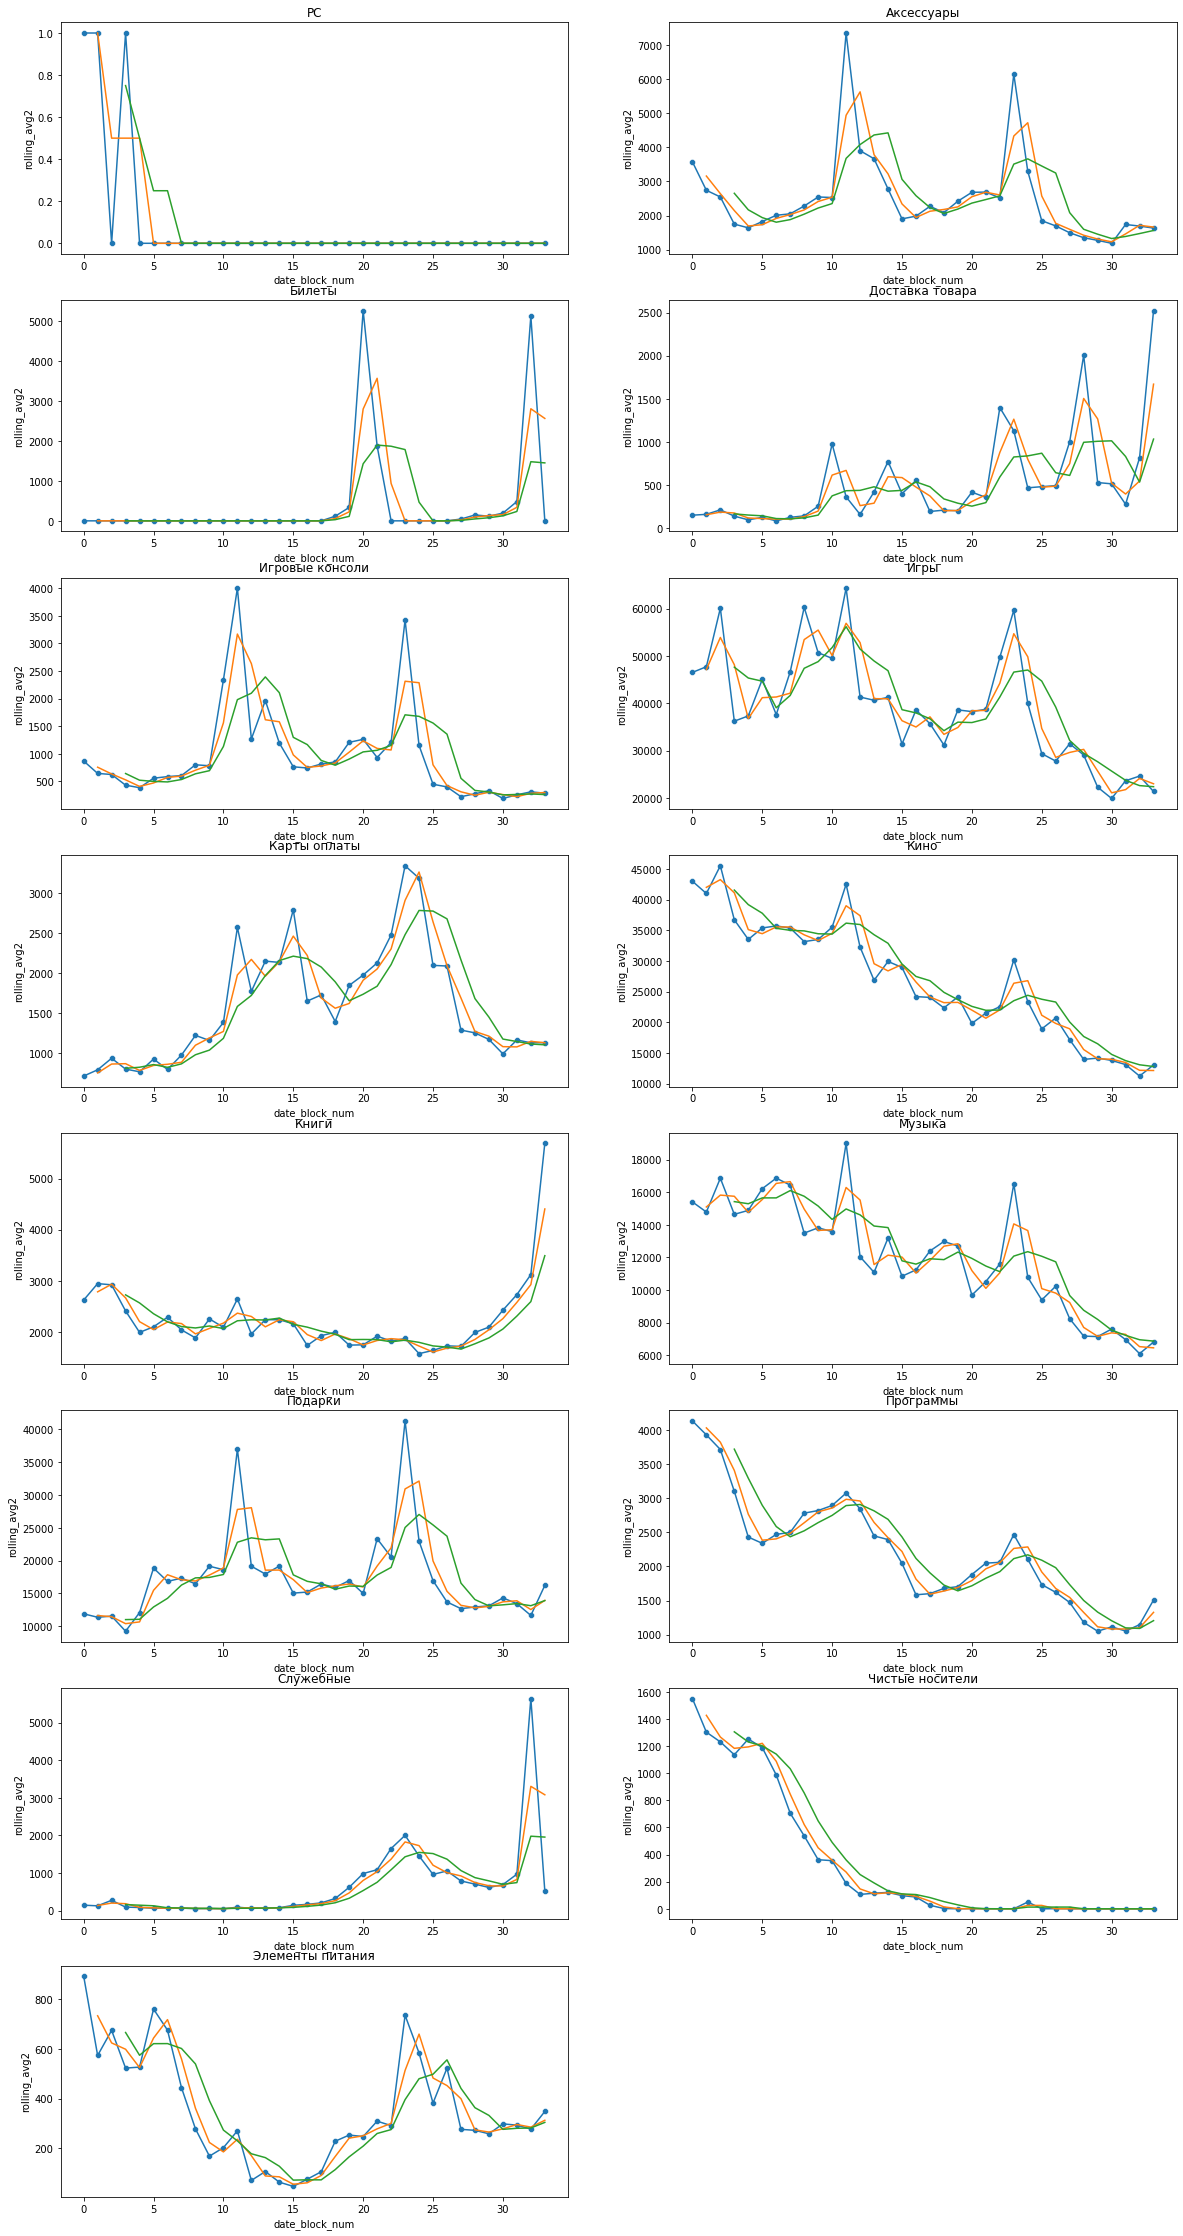

In [ ]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,40))
plot_cat_time(cat_time, cats, 'item_cnt_month', 'cat')

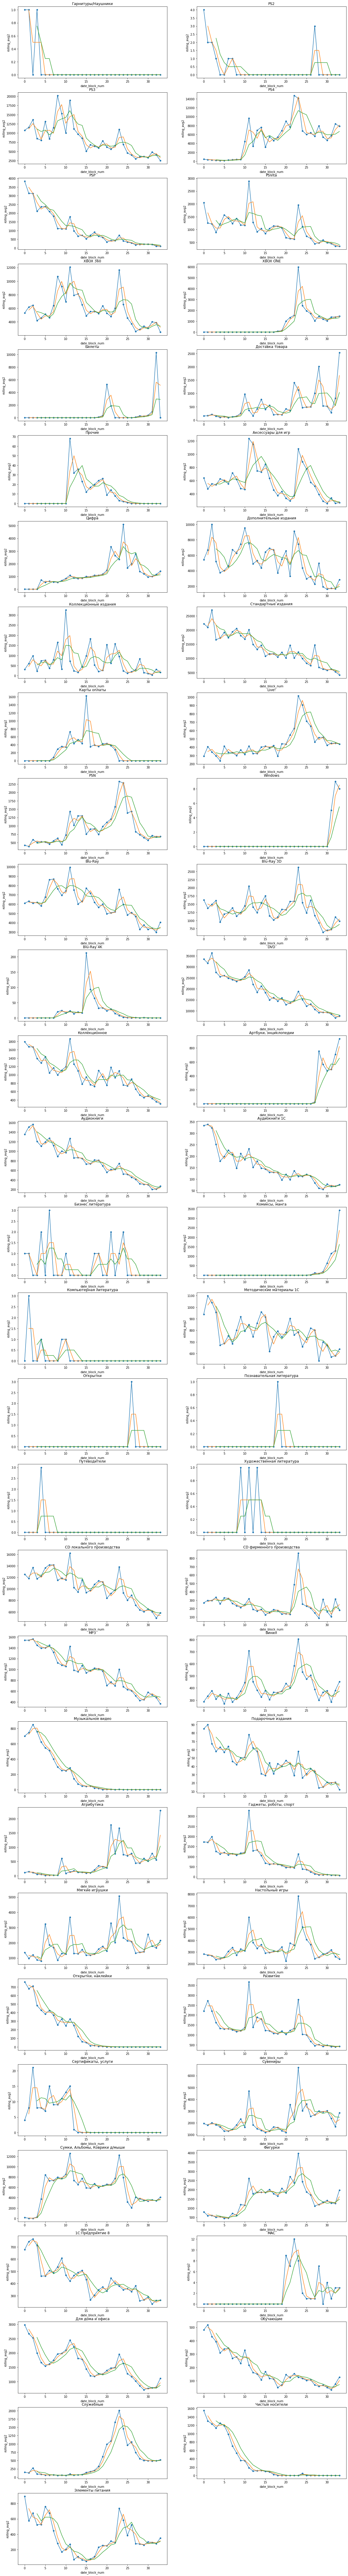

In [ ]:
cat_time = pd.DataFrame(data.groupby(['sub_cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,160))
plot_cat_time(cat_time, sub_cats, 'item_cnt_month', 'sub_cat')

Some categories have extremums in December and in almost all categories sales tend to decrease through time

# City sells througth time

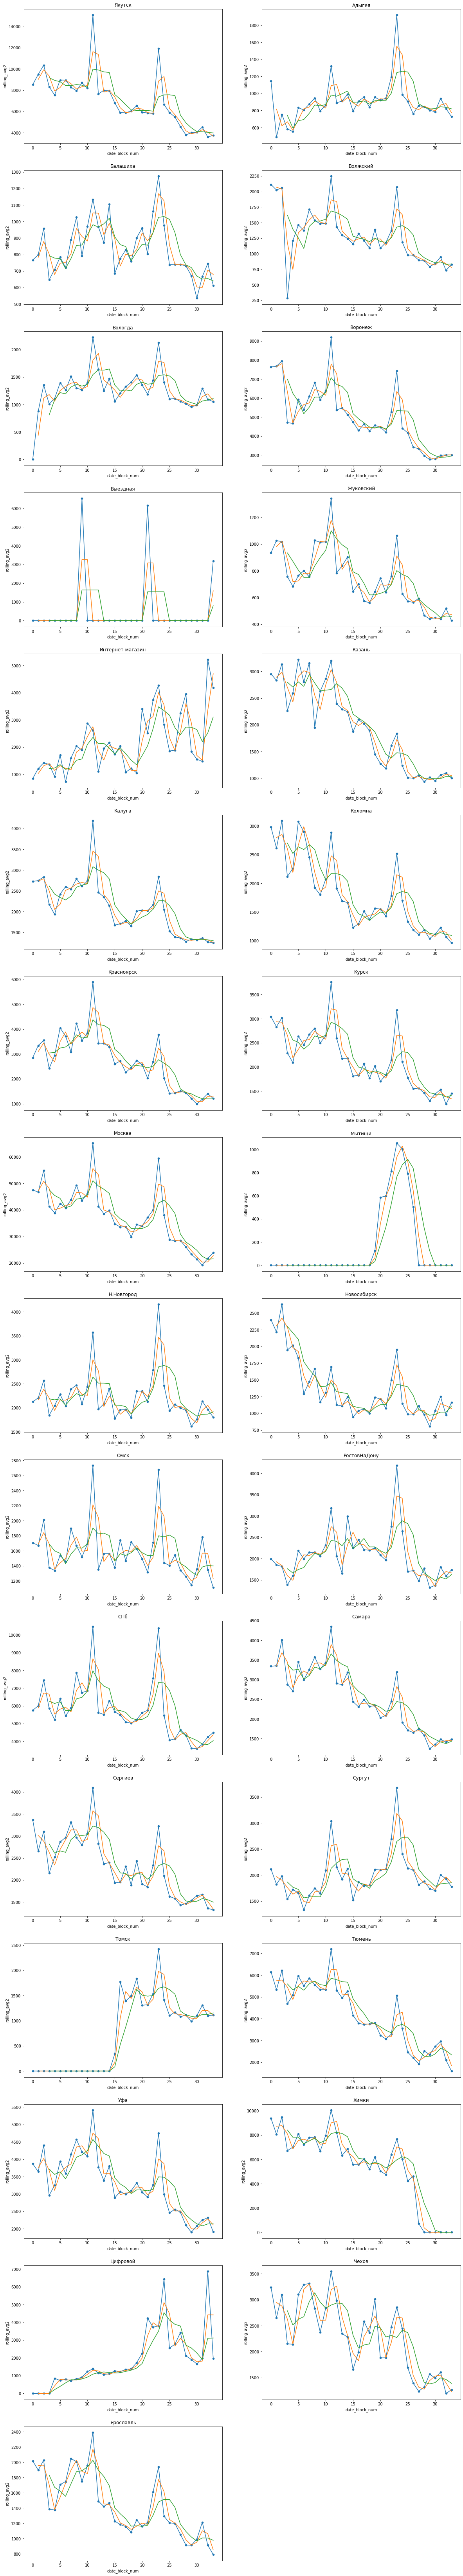

In [ ]:
shop_time = pd.DataFrame(data.groupby(['city','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,120))
plot_cat_time(shop_time, cities, 'item_cnt_month', 'city')

As in categories some cities have extremums in December

It is important to notice that "Выездная торговля" also has extremums but in different month and, more importantly, has 0 sales in other month. And the last peak was at the last month of observation. Considering that the interval between trips is at least several months it is reasonable to assume that there will be no sells next month.

# Random item sells

In [ ]:
stat = data[data.date_block_num < 32].groupby(['item_id', 'shop_id'])['item_cnt_month'].agg([np.mean, np.std]).reset_index([0,1])

In [ ]:
month33 = data[data.date_block_num == 33]

In [ ]:
len(month33)

1330200

In [ ]:
len(stat)

1330200

In [ ]:
check = pd.merge(month33, stat, on = ['item_id', 'shop_id'], how = 'left')

In [ ]:
check = check[(check.item_cnt_month > check['mean'] + 2 * check['std']) | (check.item_cnt_month < check['mean'] - 2 * check['std'])]

In [ ]:
len(check)/len(stat)

0.01308374680499173

In [ ]:
check['item_cnt_month'].describe()

count    17404.000000
mean         2.540910
std         18.216697
min         -1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2253.000000
Name: item_cnt_month, dtype: float64

In [ ]:
check = check[check.item_cnt_month > 1000]

In [ ]:
len(check)

1

In [ ]:
check = check[~(check.shop_id == 9)]

Доставка до пункта выдачи (Boxberry)
Интернет-магазин ЧС


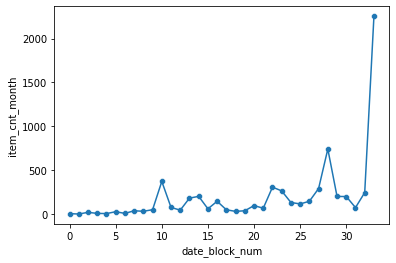

In [ ]:
s = check.sample()
sample = data[(data.item_id == s.iloc[0,0]) & (data.shop_id == s.iloc[0,1])]
print(sample.item_name.iloc[0])
print(sample.shop_name.iloc[0])
#sample = pd.DataFrame(sample.groupby('date_block_num')['item_cnt_month'].sum()).reset_index([0])

sns.scatterplot(x = sample.date_block_num,y = sample.item_cnt_month)
plt.plot(sample.date_block_num, sample.item_cnt_month)
plt.show()

# Random item price change

Зефирные наклейки Сказка алиса арт.ТMS003


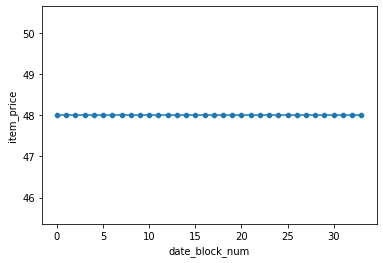

In [ ]:
sample = data[data.item_id == items.sample().iloc[0,1]]
print(sample.item_name.iloc[0])
sample = pd.DataFrame(sample.groupby('date_block_num')['item_price'].mean()).reset_index([0])
sns.scatterplot(x = sample.date_block_num,y = sample.item_price)
plt.plot(sample.date_block_num, sample.item_price)
plt.show()

# Population

Let's see if population of the city is correlated with sales in that city and by doing so check if population can be a feature decribing city

Load information about population for 2015 assuming that population does not change significantly 

In [ ]:
population = pd.read_csv('population.csv', encoding="cp1251", delimiter=';')
population = pd.merge(population, shops[['city']], on='city', how='right').drop_duplicates('city')
population 

city      pop
0             Якутск    299.0
2             Адыгея    449.0
3           Балашиха    260.0
4           Волжский    326.0
5            Вологда    318.0
6            Воронеж   1023.0
9           Выездная      NaN
10         Жуковский    107.0
12  Интернет-магазин      NaN
13            Казань   1205.0
15            Калуга    359.0
16           Коломна    144.0
17        Красноярск   1052.0
19             Курск    435.0
20            Москва  12197.0
33            Мытищи    187.0
34        Н.Новгород   1267.0
36       Новосибирск   1567.0
38              Омск   1173.0
39      РостовНаДону   1114.0
42               СПб   5191.0
44            Самара   1171.0
46           Сергиев    106.0
47            Сургут    340.0
48             Томск    564.0
49            Тюмень    697.0
52               Уфа   1105.0
54             Химки    232.0
55          Цифровой      NaN
56             Чехов     69.0
59         Ярославль    603.0

We see that there are locations which are not cities. We'll try to predict population there based on average sales in the location

In [ ]:
cities_total = data.groupby(['city', 'date_block_num'])['item_cnt_month'].sum().reset_index([0,1])
cities_total = cities_total.groupby('city')['item_cnt_month'].mean()
cities_total = pd.merge(cities_total, population, on = 'city')
pred = cities_total[cities_total['pop'].isnull()]
cities_total = cities_total.dropna()

In [ ]:
cities_total.corr().iloc[0,1]

0.9226886803229097

The correlation is in fact very big so we can use simple linear regression for the purpose of prediction

In [ ]:
from sklearn.linear_model import LinearRegression
X = cities_total.item_cnt_month.values
y = cities_total['pop'].values
lr = LinearRegression()
lr.fit(X.reshape(-1, 1),y)
pred['pop'] = lr.predict(np.array(pred.item_cnt_month).reshape(-1, 1) )
pred

city  item_cnt_month         pop
5           Выездная      466.647059  177.785061
7   Интернет-магазин     2161.117647  717.459027
27          Цифровой     1864.352941  622.942081

Now concatenate this information with cities and save it

In [ ]:
population = pd.concat((population.dropna(), pred.drop(['item_cnt_month'], axis = 1)))

In [ ]:
population.to_csv('population_full.csv', sep=';')

Now let's check correlation with population 

In [ ]:
city_month = data[data.date_block_num >=28].groupby(['date_block_num', 'city', 'shop_id'])[['item_cnt_month']].sum().reset_index([0,1,2])
print("Aggregated by ['date_block_num', 'city', 'shop_id']")
city_month = pd.merge(city_month, population, on = 'city', how = 'left')
city_month.drop(['date_block_num', 'shop_id'], axis = 1).corr().iloc[0,1]

Aggregated by ['date_block_num', 'city', 'shop_id']


0.2613426081307769

In [ ]:
city_month = data[data.date_block_num >=28].groupby(['date_block_num','city'])[['item_cnt_month']].sum().reset_index([0,1])
print("Aggregated by ['date_block_num', 'city']")
city_month = pd.merge(city_month, population, on = 'city', how = 'left')
city_month.drop(['date_block_num'], axis = 1).corr().iloc[0,1]

Aggregated by ['date_block_num', 'city']


0.9239664855603679

We see that population works well as the characteristic for the city but not for the shop

# Number of shops

Now consider number of shops in a city as a characteristic for city

In [ ]:
temp = data[data.date_block_num >=28].groupby(['city', 'date_block_num'])[['shop_id']].nunique()
temp.columns = ['shop_cnt']
temp = temp.reset_index([0,1])

In [ ]:
pd.merge(city_month, temp, on = ['city', 'date_block_num']).drop(['date_block_num'], axis= 1).corr()

item_cnt_month       pop  shop_cnt
item_cnt_month        1.000000  0.923966  0.938631
pop                   0.923966  1.000000  0.891315
shop_cnt              0.938631  0.891315  1.000000

Shop count also greatly correlates with sales in a city

# City - category

In [ ]:
temp = data.groupby(['city','cat' ])['item_cnt_month'].sum().reset_index([0,1])

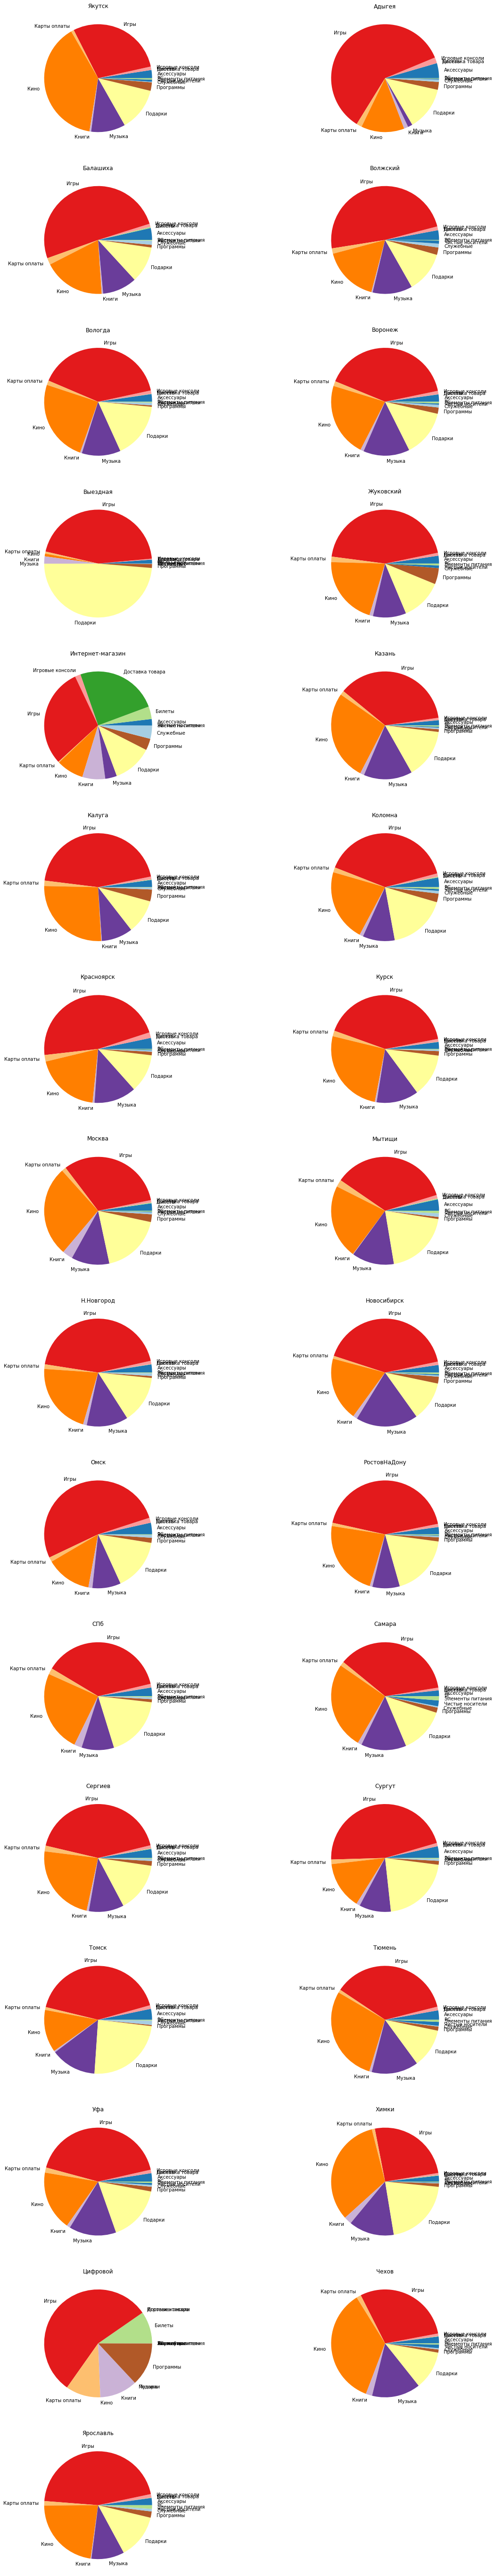

In [ ]:
plt.figure(figsize=(20,100))
colors = sns.color_palette('Paired')[:len(cats)]
for i, c in enumerate(cities):
        t = temp.groupby('city').get_group(c)
        plt.subplot(len(cities)//2 + 1,2, i+1)
        plt.pie(t.item_cnt_month,labels=t.cat, colors=colors)
        plt.title(c)

It is clear that most cities have the same 'intrests' but there are some differenses for instance in "Выездная торговля", "Якутск", "Адыгея", "Интернет - магазин", "Цифровой склад"

# Sells in closed shops

Let's see the distribution of sales in closed shops to see if there are any patterns

In [ ]:
temp = data[data.shop_id.isin(closed_shops)].groupby(['shop_id', 'date_block_num'])[['item_cnt_month']].sum().groupby('shop_id')

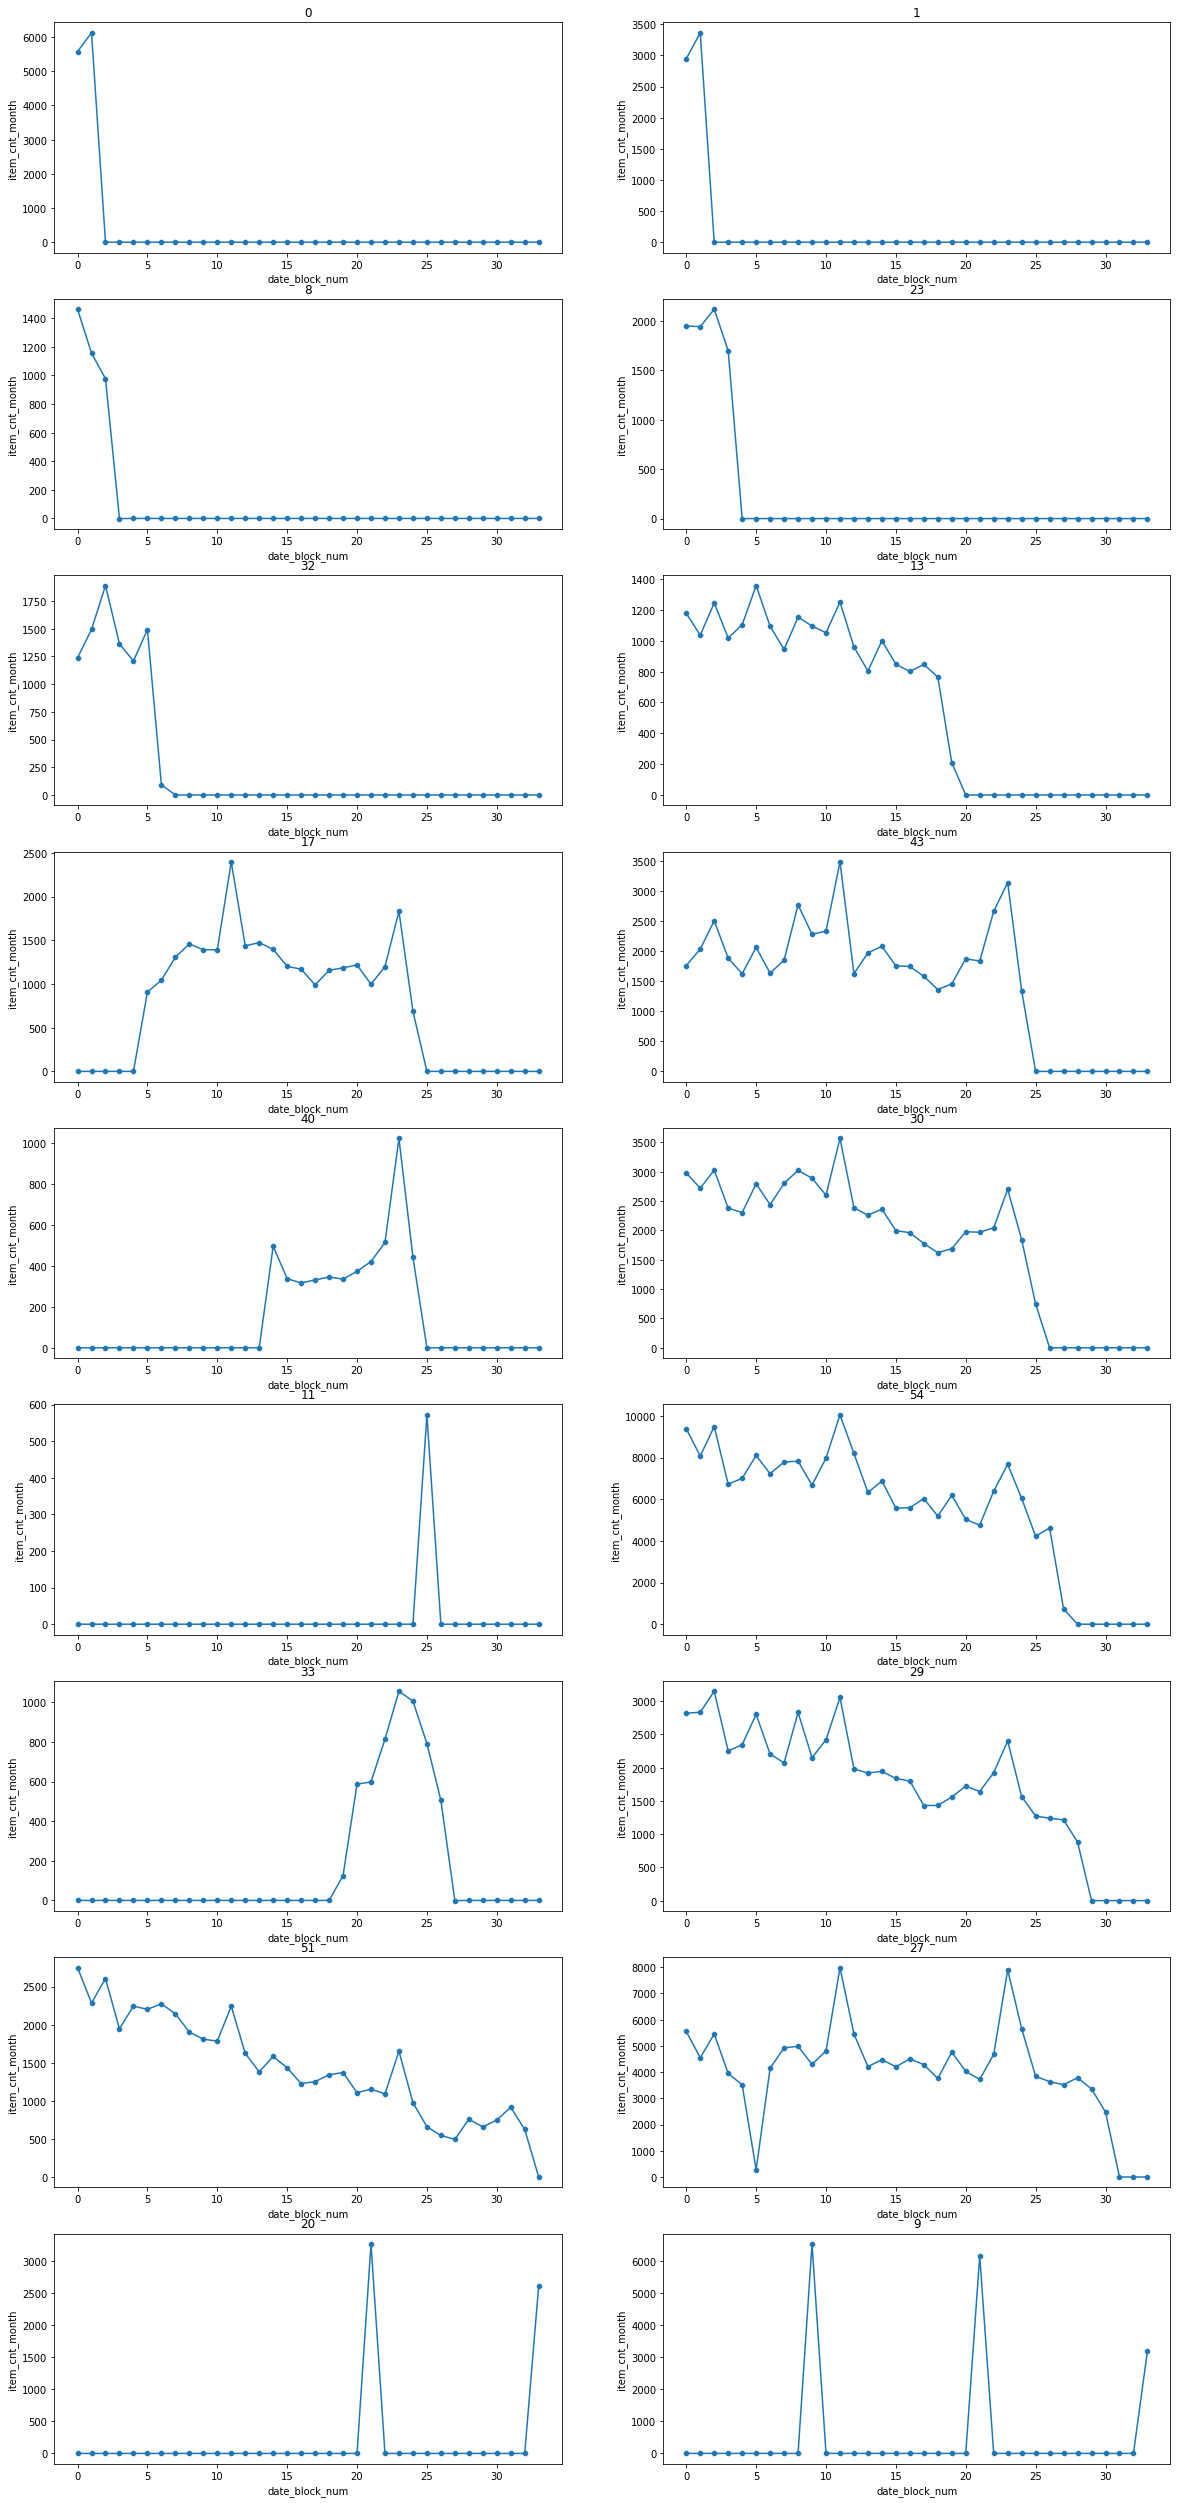

In [ ]:
plt.figure(figsize=(20,50))
for i, s in enumerate(closed_shops):
    t = temp.get_group(s)
    t = pd.merge(t, m, on = 'date_block_num', how = 'right')
    plt.subplot(len(closed_shops)//2 + 1,2, i+1)
    sns.scatterplot(x = t.date_block_num,y = t['item_cnt_month'])
    plt.plot( t.date_block_num, t['item_cnt_month'])
    plt.title(s)

So we see that there is decrease in sales

Let's look at the suspicios shops

In [ ]:
shops[shops.shop_id.isin([9, 11, 20])]

shop_name  shop_id       city
9            Выездная Торговля        9   Выездная
11  Жуковский ул. Чкалова 39м²       11  Жуковский
20         Москва "Распродажа"       20     Москва

* "Выездная торговля" was falsely marked as closed. And it was already noticed before. 
* Shop in  "Жуковский" was opened only for 1 month and it looks fine.
* And "Москва "Распродажа"" is kind of the same as "Выездная торговля" but only on a different level. The interval between sales is rather long and the last sale was in the last month of observation so it is reasonable to assume that there will be 0 sales next month

# First and last month of sales for each item

In [ ]:
item_date_points = data[data.item_cnt_month != 0].groupby('item_id').agg({'date_block_num' : ['min', 'max']})
item_date_points.columns = item_date_points.columns.droplevel(0)
item_date_points = pd.merge(item_date_points, items, on = 'item_id', how = 'right').fillna(0)

Text(0.5, 1.0, 'Last month of sales')

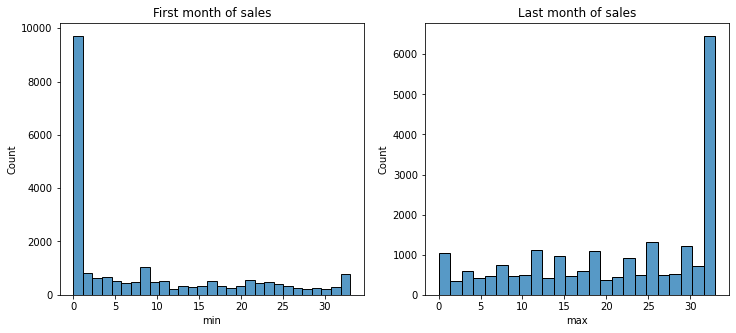

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2, 1)
sns.histplot(data = item_date_points, x = 'min')
plt.title('First month of sales')
plt.subplot(1,2, 2)
sns.histplot(data = item_date_points, x = 'max')
plt.title('Last month of sales')

In [ ]:
item_date_points = item_date_points.drop(['item_name'], axis=1)
last_month_sales = data[data.date_block_num == 33].groupby('item_id')[['item_cnt_month']].sum()
item_date_points = pd.merge(item_date_points, last_month_sales, on='item_id')
item_date_points['dif'] = item_date_points['max'] - item_date_points['min']

In [ ]:
item_date_points.drop(['item_id', 'item_category_id'], axis=1).corr()

min       max  item_cnt_month       dif
min             1.000000  0.550061        0.096182 -0.444269
max             0.550061  1.000000        0.094501  0.503807
item_cnt_month  0.096182  0.094501        1.000000  0.001891
dif            -0.444269  0.503807        0.001891  1.000000

There is no correlation

Let's look at distribution of sales in shop

In [ ]:
mean_sales_shops = data.groupby(['shop_id', 'date_block_num'])[['item_cnt_month']].sum().reset_index([0,1])
mean_sales_shops = mean_sales_shops.groupby('shop_id')[['item_cnt_month']].mean()

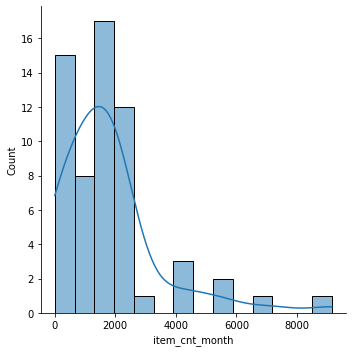

In [ ]:
sns.displot(data = mean_sales_shops, x = 'item_cnt_month' , kde = True)

# Mean sales in shops vs last month sales

Check how well previous sells correlate with sales of last month

In [ ]:
last_month_sales = data[data.date_block_num == 33].groupby('shop_id')[['item_cnt_month']].sum()

In [ ]:
print('Average sales and last month sales')
pd.merge(mean_sales_shops.reset_index([0]), last_month_sales, on = 'shop_id').drop(['shop_id'], axis = 1).corr().iloc[0,1]

Average sales and last month sales


0.7083361044104365

# Mean sales for the past 4 month vs last month sales

In [ ]:
mean_sales_shops = data[data.date_block_num.isin([29, 30, 31, 32])].groupby(['shop_id', 'date_block_num'])[['item_cnt_month']].sum().reset_index([0,1])
mean_sales_shops = mean_sales_shops.groupby('shop_id')[['item_cnt_month']].mean()

In [ ]:
print("Average sales for the past 4 month and last month\n ['shop_id', 'date_block_num'] ")
pd.merge(mean_sales_shops.reset_index([0]), last_month_sales, on = 'shop_id').drop(['shop_id'], axis = 1).corr().iloc[0,1]

Average sales for the past 4 month and last month
 ['shop_id', 'date_block_num'] 


0.8720611131729052

In [ ]:
mean_sales_shops = data[data.date_block_num.isin([29, 30, 31, 32])].groupby(['item_id', 'date_block_num'])[['item_cnt_month']].sum().reset_index([0,1])
mean_sales_shops = mean_sales_shops.groupby('item_id')[['item_cnt_month']].mean()
last_month_sales = data[data.date_block_num == 33].groupby('item_id')[['item_cnt_month']].sum()
print("Average sales for the past 4 month and last month\n ['item_id', 'date_block_num'] ")
pd.merge(mean_sales_shops.reset_index([0]), last_month_sales, on = 'item_id').drop(['item_id'], axis = 1).corr().iloc[0,1]

Average sales for the past 4 month and last month
 ['item_id', 'date_block_num'] 


0.7710572683068406

# Last year sales vs this year sales for each month

In [ ]:
data['month'] = (data.date_block_num % 12 + 1).astype(np.int8)

In [ ]:
for random_month in list(range(1,10)):
    group1 = data.groupby(['month', 'date_block_num']).get_group((random_month, random_month + 11))[['item_id', 'shop_id', 'item_cnt_month']]
    group2 = data.groupby(['month', 'date_block_num']).get_group((random_month, random_month + 23))[['item_id', 'shop_id', 'item_cnt_month']]
    c = pd.merge(group1, group2, on = ['item_id', 'shop_id'])[['item_cnt_month_x','item_cnt_month_y']].corr()
    print(random_month)
    print(c)


1
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.560473
item_cnt_month_y          0.560473          1.000000
2
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.427792
item_cnt_month_y          0.427792          1.000000
3
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.243159
item_cnt_month_y          0.243159          1.000000
4
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.231026
item_cnt_month_y          0.231026          1.000000
5
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.454282
item_cnt_month_y          0.454282          1.000000
6
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.687964
item_cnt_month_y          0.687964          1.000000
7
                  item_cnt_month

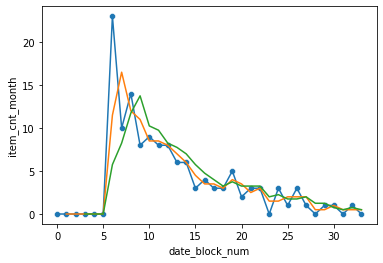

In [ ]:
sample = data[data.item_id == items.sample().iloc[0,1]]
name = 'item_cnt_month'
sample = pd.DataFrame(sample.groupby('date_block_num')['item_cnt_month'].sum()).reset_index([0])
sample['rolling_avg2'] = sample[name].rolling(2).mean()
sample['rolling_avg4'] = sample[name].rolling(4).mean()

#a = pd.merge(sample,m, on = 'date_block_num', how = 'right').fillna(0)

sns.scatterplot(x = sample.date_block_num,y = sample.item_cnt_month)
plt.plot( sample.date_block_num, sample.item_cnt_month)
sns.lineplot( x = 'date_block_num', y = 'rolling_avg2', data = sample)
sns.lineplot( x = 'date_block_num', y = 'rolling_avg4', data = sample)

# Notes

* 363 items were not sold at all
a lot of items were sold only for a short period of time(1 month)
it is necessary to explore this items more carefully(probably we can devide them into categories)

* a lot of outliers in price column and item_cnt_day column
big value of item_cnt_day may be a sign of продажи оптом
they appear in almost all months

* some shops have very low sales number. it may be explained by different opening time. 
maybe a month of opening might be useful for predictions
* some categories have very low sales. it may make sense to unite them into one

* huge variance in price within every category 
the biggest variance is seen in categories with the highest sales. it may be explained by the variety of goods in this category
maybe it would make sence to divide them into smaller categories 

* overall sales tend to decrease an it is clear that there are peaks in december

* dollar correlates well with total item_cnt_month(sum for all items) and mean item_price
but we should be careful because it also correlates with date_block_num

* dollar affects different categories differently

* if we look at the random item count distribution through time we 
will notice that most items were sold only for a short period of time and most items have one peak
maybe we can cluster items by their sales distribution
cause you can notice some patterns and similarities

* some months have strong correlation in sales (min 0.35 max 0.97)
* some months have strong correlation in sales per shop

* some shops were opened after 2013*01 and some were closed before 2015*10
low correlation between some months can be explained by closed and opened shops

* population correlates well with total sells in a city as well as amount of shops in a city

